In [1]:
from utils_visualization import *

import os
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import logging as logger
import seaborn as sns
import matplotlib.colors as mcolors
import plotly.express as px
from scipy.stats import gaussian_kde

import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

logger.basicConfig(level=logger.INFO, format='%(asctime)s - %(message)s', datefmt='%d-%b-%y %H:%M:%S', filename='visualization.log')

In [2]:
cmap_dict = sns.color_palette(palette=["#C8FFC8", "#00C800", "#007800", "#FFFF00", "#FFC878", "#FF9600", "#FF0000", "#780000", "#FF00FF", "#8C3CFF", "#000078"],n_colors=11)

hex_colors = [mcolors.to_hex(color) for color in cmap_dict]
custom_color_scale = [[i/len(hex_colors), color] for i, color in enumerate(hex_colors)]
custom_color_scale.append([1, hex_colors[-1]])

def leq(levels):
    levels = levels[~np.isnan(levels)]
    l = np.array(levels)
    return 10*np.log10(np.mean(np.power(10,l/10)))


COLOR_PALLET_PORT_L1 = {
            'Siren': '#2986cc', # BLUE
            'Sound Event': '#cc0000', # RED
            'Transport': '#6aa84f', #  green 6aa84f
            'Human': '#ffa500', # orange
            'Nature': '#8e7cc3', # PURPLE
            'Animal': '#9b5f00', # BROWN
            'Music': '#d172a4', # PINK
            'Engine': '#000000', # BLACK
        }

In [3]:
yamnet = pd.read_csv(r"C:\Users\scjaa\AAC - CENTRO DE ACUSTICA APLICADA, S.L\I + D + i - Documentos\Modelos_IA\AAC_IA_Puerto\yamnet_class_AAC_v3_0.csv",sep=';')

yamnet = yamnet.drop(columns=['index', 'Brown_Level_1'])
yamnet = yamnet.loc[:, ~yamnet.columns.str.contains('^Unnamed')]

yamnet

,mid,display_name,iso_taxonomy,Brown_Level_2,Brown_Level_3,NoisePort_Level_1,NoisePort_Level_2
0,/m/09x0r,Speech,Voice,Voice,speech,Human,Voice
1,/m/0ytgt,"Child speech, kid speaking",Voice,Voice,speech,Human,Voice
2,/m/01h8n0,Conversation,Voice,Voice,speech,Human,Voice
3,/m/02qldy,"Narration, monologue",Voice,Voice,speech,Human,Voice
4,/m/0261r1,Babbling,Voice,Voice,speech,Human,Voice
...,...,...,...,...,...,...,...
516,/m/07p_0gm,Throbbing,Background,Other Sounds,noise,Music,Music
517,/m/01jwx6,Vibration,Background,Other Sounds,noise,Engine,Machinery
518,/m/07c52,Television,Background,Social/communal,domestic,Sound Event,Voice
519,/m/06bz3,Radio,Background,Social/communal,domestic,Sound Event,Voice


In [4]:
# csv_file = r"\\192.168.205.117\AAC_Server\PUERTOS\NOISEPORT\20231211_SANTUR\5-Resultados\P3_CONTENEDORES\SPL\Peaks\peak_prediction_P3_CONTENEDORES.csv"
csv_file = r"\\192.168.205.123\aac_server\PUERTOS\NOISEPORT\20231129_SANTUR\5-Resultados\muelle-princesa-P4\SPL\Peaks\peak_prediction_muelle-princesa-P4.csv"


title = csv_file.split('\\')[-4].split('.')[0]
print(title)

folder_output = csv_file.split('\\')[:-1]
folder_output = '\\'.join(folder_output)
print(folder_output)

folder_output = os.path.join(folder_output, 'Graphic_analysis')
os.makedirs(folder_output, exist_ok=True)
print(folder_output)


df = pd.read_csv(csv_file)

df = add_datetime_columns(df,logger, date_col='start_time') 
df = df.sort_values('start_time')
df.set_index('start_time', inplace=True, drop=False)
df.index.name = 'datatime'

start_date = df.index[0]
end_date = df.index[-1]

logger.info(f"Start date {start_date} and end date {end_date}")
logger.info(f"df was sorted by datetime and datetime was set as index")

df['indicador_str'] = df.apply(lambda x: evaluation_period_str(x['hour']), axis=1)
df['night_str'] = df.apply(lambda x: add_night_column(x['hour'], x['weekday']), axis=1)
df['classes'] = df['classes'].apply(ast.literal_eval)


df_exploded = df.explode('classes')
df_merged = pd.merge(df_exploded, yamnet, left_on='classes', right_on='display_name', how='left')

# rename columns
df_merged = df_merged.rename(columns={'classes':'class', 'leq':'LAeq'})
df_merged

muelle-princesa-P4
\\192.168.205.123\aac_server\PUERTOS\NOISEPORT\20231129_SANTUR\5-Resultados\muelle-princesa-P4\SPL\Peaks
\\192.168.205.123\aac_server\PUERTOS\NOISEPORT\20231129_SANTUR\5-Resultados\muelle-princesa-P4\SPL\Peaks\Graphic_analysis


,filename,start_time,end_time,duration,class,predictions,LAeq,LA_values,date,day,...,day_name,indicador_str,night_str,mid,display_name,iso_taxonomy,Brown_Level_2,Brown_Level_3,NoisePort_Level_1,NoisePort_Level_2
0,\\192.168.205.117\AAC_Server\PUERTOS\NOISEPORT...,2023-11-29 12:17:18,2023-11-29 12:17:25,7.5,Bicycle,"[0.3083945, 0.14657761]",79.81,"[75.8, 78.23, 80.78, 80.0, 81.88]",2023-11-29,29,...,Wednesday,Ld,,/m/0199g,Bicycle,non motorized,Human movement,non motorized,Engine,Vehicle
1,\\192.168.205.117\AAC_Server\PUERTOS\NOISEPORT...,2023-11-29 12:17:18,2023-11-29 12:17:25,7.5,Vehicle,"[0.3083945, 0.14657761]",79.81,"[75.8, 78.23, 80.78, 80.0, 81.88]",2023-11-29,29,...,Wednesday,Ld,,/m/07yv9,Vehicle,Roadway traffic,Motorised transport,roadway traffic,Engine,Vehicle
2,\\192.168.205.117\AAC_Server\PUERTOS\NOISEPORT...,2023-11-29 12:19:49,2023-11-29 12:19:51,2.5,Wind,"[0.2714036, 0.26486522]",73.15,"[71.09, 74.59, 73.07]",2023-11-29,29,...,Wednesday,Ld,,/m/03m9d0z,Wind,Wind,Geonature,wind,Nature,Wind
3,\\192.168.205.117\AAC_Server\PUERTOS\NOISEPORT...,2023-11-29 12:19:49,2023-11-29 12:19:51,2.5,Wind noise (microphone),"[0.2714036, 0.26486522]",73.15,"[71.09, 74.59, 73.07]",2023-11-29,29,...,Wednesday,Ld,,/t/dd00092,Wind noise (microphone),Wind,Geonature,wind,Nature,Wind
4,\\192.168.205.117\AAC_Server\PUERTOS\NOISEPORT...,2023-11-29 12:28:56,2023-11-29 12:28:57,1.5,Vehicle,"[0.1883349, 0.14215572]",74.54,"[72.94, 75.71]",2023-11-29,29,...,Wednesday,Ld,,/m/07yv9,Vehicle,Roadway traffic,Motorised transport,roadway traffic,Engine,Vehicle
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2481,\\192.168.205.117\AAC_Server\PUERTOS\NOISEPORT...,2023-12-07 20:49:13,2023-12-07 20:49:14,1.5,Wind noise (microphone),"[0.5022389, 0.48235774]",70.66,"[67.96, 72.31]",2023-12-07,7,...,Thursday,Le,,/t/dd00092,Wind noise (microphone),Wind,Geonature,wind,Nature,Wind
2482,\\192.168.205.117\AAC_Server\PUERTOS\NOISEPORT...,2023-12-07 20:50:28,2023-12-07 20:50:31,3.5,Speech,"[0.19509986, 0.19083287]",70.68,"[66.87, 70.87, 72.55]",2023-12-07,7,...,Thursday,Le,,/m/09x0r,Speech,Voice,Voice,speech,Human,Voice
2483,\\192.168.205.117\AAC_Server\PUERTOS\NOISEPORT...,2023-12-07 20:50:28,2023-12-07 20:50:31,3.5,Vehicle,"[0.19509986, 0.19083287]",70.68,"[66.87, 70.87, 72.55]",2023-12-07,7,...,Thursday,Le,,/m/07yv9,Vehicle,Roadway traffic,Motorised transport,roadway traffic,Engine,Vehicle
2484,\\192.168.205.117\AAC_Server\PUERTOS\NOISEPORT...,2023-12-08 02:06:41,2023-12-08 02:06:44,3.5,Animal,"[0.11167023, 0.06489019]",59.00,"[58.22, 58.69, 59.92]",2023-12-08,8,...,Friday,Ln,Jueves-Viernes,/m/0jbk,Animal,Nature,Animal,Animal,Animal,Animal


In [5]:
print(start_date)
print(end_date)

2023-11-29 12:17:18
2023-12-08 02:06:41


In [6]:
file_path = r"\\192.168.205.123\aac_server\PUERTOS\NOISEPORT\EMBARQUES\port_bilbao_2023.xlsx"
df_embarques = pd.read_excel(file_path)

df_embarques = df_embarques[['MUELLE','DESCRIPCION_TIPO_BUQUE', 'FECHA_HORA_ENTRADA_POR_PUNTAS', 'FECHA_HORA_SALIDA_POR_PUNTAS']]

df_embarques['FECHA_HORA_ENTRADA_POR_PUNTAS'] = pd.to_datetime(df_embarques['FECHA_HORA_ENTRADA_POR_PUNTAS'], dayfirst=True, errors='coerce')
df_embarques['FECHA_HORA_SALIDA_POR_PUNTAS'] = pd.to_datetime(df_embarques['FECHA_HORA_SALIDA_POR_PUNTAS'], dayfirst=True, errors='coerce')
# df_embarques = df_embarques[df_embarques['DESCRIPCION_TIPO_BUQUE'].str.contains('Contenedores')]
df_embarques = df_embarques[df_embarques['MUELLE'].str.contains('MUELLE A1')]# NEMAR 1

# filter based on the date range
df_embarques = df_embarques[(df_embarques['FECHA_HORA_ENTRADA_POR_PUNTAS'] >= start_date) & (df_embarques['FECHA_HORA_SALIDA_POR_PUNTAS'] <= end_date)]
# sort by date
df_embarques = df_embarques.sort_values('FECHA_HORA_ENTRADA_POR_PUNTAS')
df_embarques
# print(len(df_embarques))

,MUELLE,DESCRIPCION_TIPO_BUQUE,FECHA_HORA_ENTRADA_POR_PUNTAS,FECHA_HORA_SALIDA_POR_PUNTAS
929,MUELLE A1,Contenedores ...,2023-11-29 15:15:00,2023-11-30 13:10:00
937,MUELLE A1,Contenedores ...,2023-12-01 06:20:00,2023-12-01 15:05:00
940,MUELLE A1,Contenedores ...,2023-12-01 22:10:00,2023-12-03 02:05:00
943,MUELLE A1,Contenedores ...,2023-12-03 02:10:00,2023-12-04 05:05:00
947,MUELLE A1,Contenedores ...,2023-12-03 19:10:00,2023-12-05 09:50:00
957,MUELLE A1,Contenedores ...,2023-12-04 10:35:00,2023-12-04 19:25:00
960,MUELLE A1,Contenedores ...,2023-12-05 05:30:00,2023-12-06 07:55:00
967,MUELLE A1,Contenedores ...,2023-12-06 01:55:00,2023-12-07 03:35:00
977,MUELLE A1,Contenedores ...,2023-12-07 06:10:00,2023-12-07 12:05:00
978,MUELLE A1,Contenedores ...,2023-12-07 10:30:00,2023-12-07 18:25:00


In [7]:
display_name = 'display_name'
iso_taxonomy = 'iso_taxonomy'
classes = 'class'

brown_1 = 'Brown_Level_1'
brown_2 = 'Brown_Level_2'
brown_3 = 'Brown_Level_3'
noiseport_1 = 'NoisePort_Level_1'
noiseport_2 = 'NoisePort_Level_2'

class_to_plot = noiseport_1

grouped_df = df_merged.groupby(class_to_plot).agg(
            number=(classes, 'size'),
            LAeq=('LAeq', lambda x: leq(x))
        ).reset_index()

fig = px.treemap(grouped_df, 
                path=[class_to_plot],  
                values='number',
                color='LAeq',
                color_continuous_scale=custom_color_scale,
                range_color=[30, 85],
                hover_data={'LAeq': True, 'number': True},
                custom_data=['LAeq'],                  
                )

fig.update_layout(title=f'{title} Promedio Energético (LAeq) por Clases de Picos encontrados')
fig.update_traces(hovertemplate='<b>%{label}</b><br>LAeq: %{customdata[0]:.2f} dB<br>Count: %{value}')
fig.update_traces(texttemplate='%{label}<br><br>LAeq: %{customdata[0]:.2f} dB')
fig.show()

# fig.write_html(os.path.join(folder_output, f'{title}_LAeq_class_mean.html'))
# save the csv file
# grouped_df.to_csv(os.path.join(folder_output, f'{title}_LAeq_class_mean.csv'))

In [8]:
dfg = df_merged.groupby([class_to_plot, 'day']).count().reset_index()
fig = px.bar(
    dfg, 
    x='day',
    y='start_time',
    color=class_to_plot,
    title=f'{title} Clases por día desde {start_date} hasta {end_date}',
    color_discrete_sequence=px.colors.qualitative.Alphabet, 
    color_discrete_map=COLOR_PALLET_PORT_L1,
    height=900,
    width=2000
)
fig.show()

fig.write_html(os.path.join(folder_output, f'{title}_prediction_stack_map.html'))
# save the csv file
dfg.to_csv(os.path.join(folder_output, f'{title}_prediction_stack_map.csv'))

In [9]:
df_merged.columns

Index(['filename', 'start_time', 'end_time', 'duration', 'class',
       'predictions', 'LAeq', 'LA_values', 'date', 'day', 'hour', 'weekday',
       'day_name', 'indicador_str', 'night_str', 'mid', 'display_name',
       'iso_taxonomy', 'Brown_Level_2', 'Brown_Level_3', 'NoisePort_Level_1',
       'NoisePort_Level_2'],
      dtype='object')

## Peak distribution

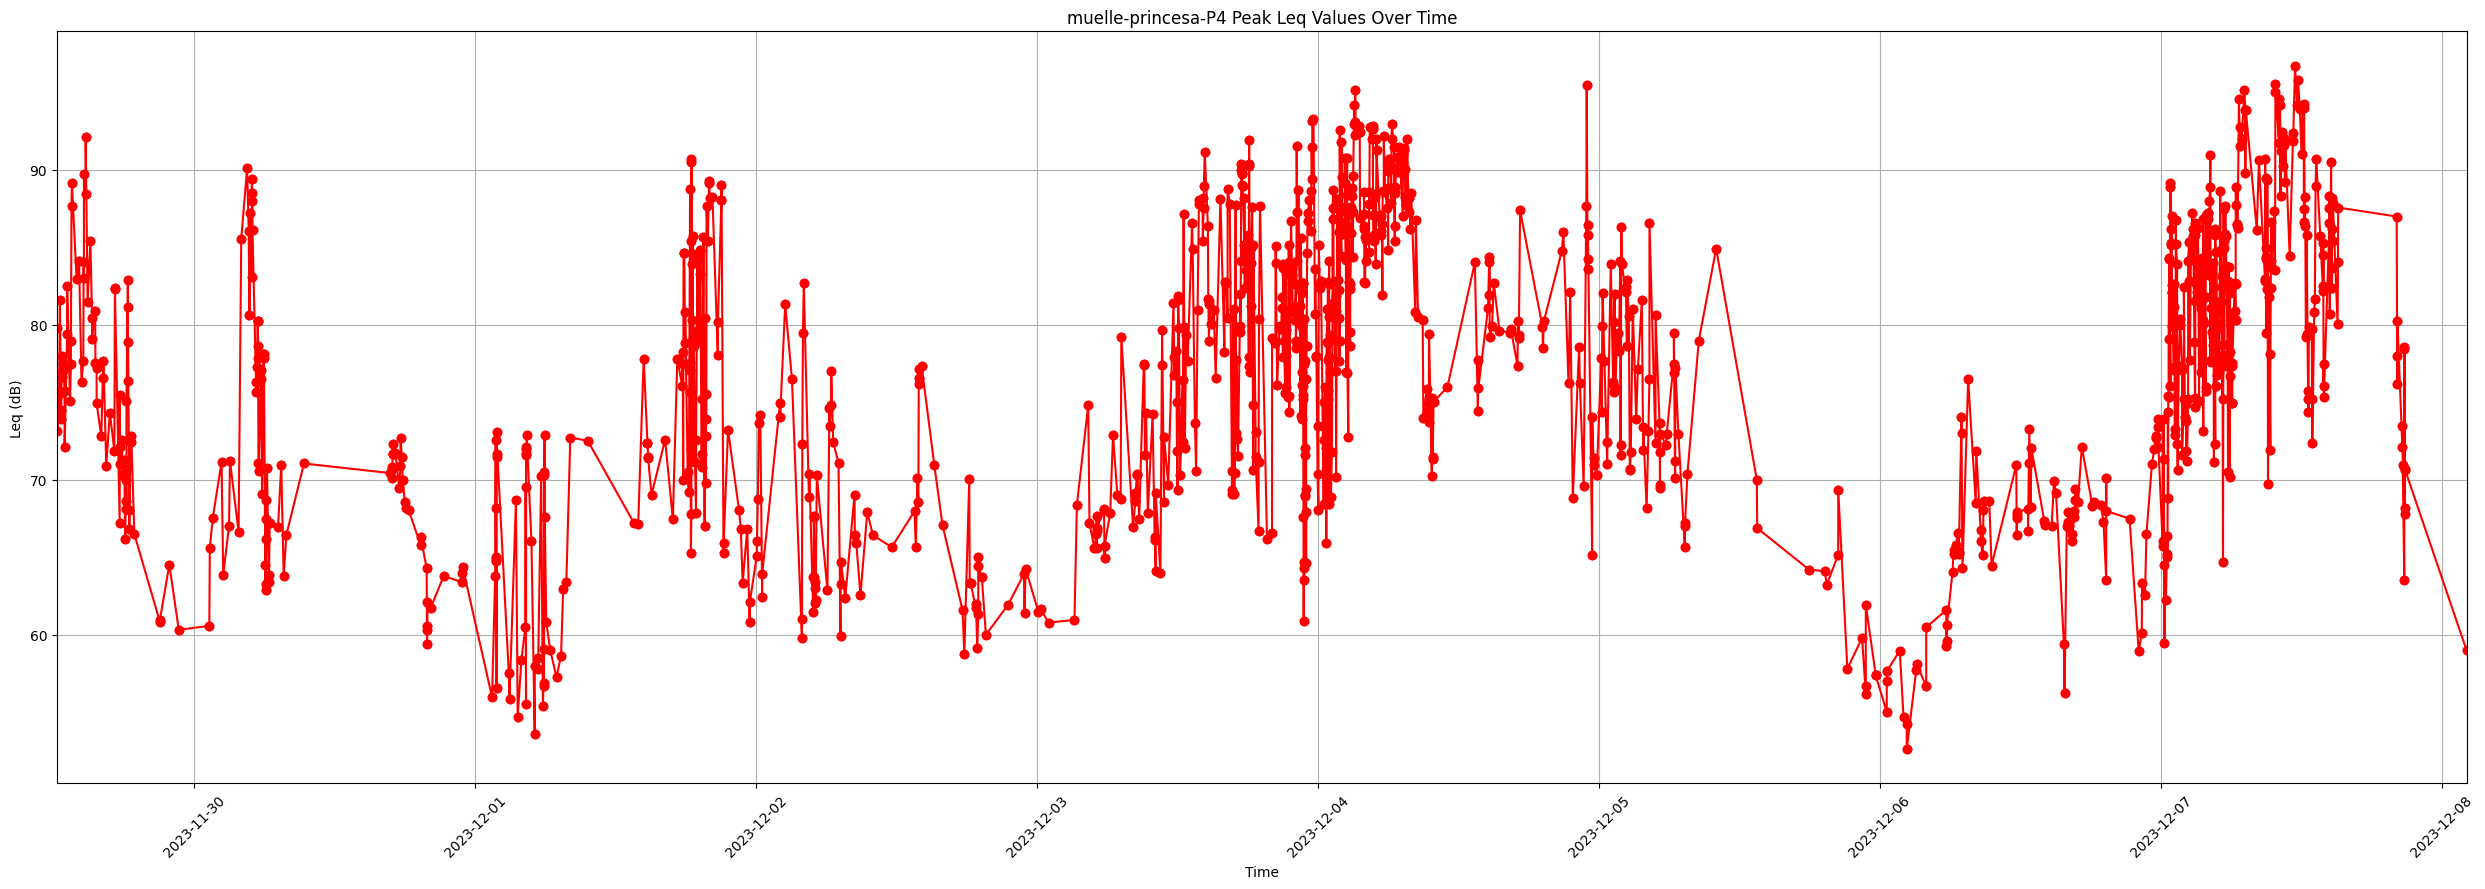

In [10]:
df_merged['start_time'] = pd.to_datetime(df_merged['start_time'])
df_merged.sort_values('start_time', inplace=True)

#plot leq over time
plt.figure(figsize=(25, 9))
plt.plot(df_merged['start_time'], df_merged['LAeq'], marker='o', linestyle='-', color='red')
plt.title(f'{title} Peak Leq Values Over Time')
plt.xlabel('Time')
plt.ylabel('Leq (dB)')
plt.grid(True)
plt.xticks(rotation=45)
# adjust blank space in the beggining and end of the plot
plt.xlim(df_merged['start_time'].iloc[0], df_merged['start_time'].iloc[-1])
plt.tight_layout()
# plt.show()

#save the plot
plt.savefig(os.path.join(folder_output, f'{title}_peak_leq.png'))
df_merged.to_csv(os.path.join(folder_output, f'{title}_peak_leq.csv'))

## Night filter

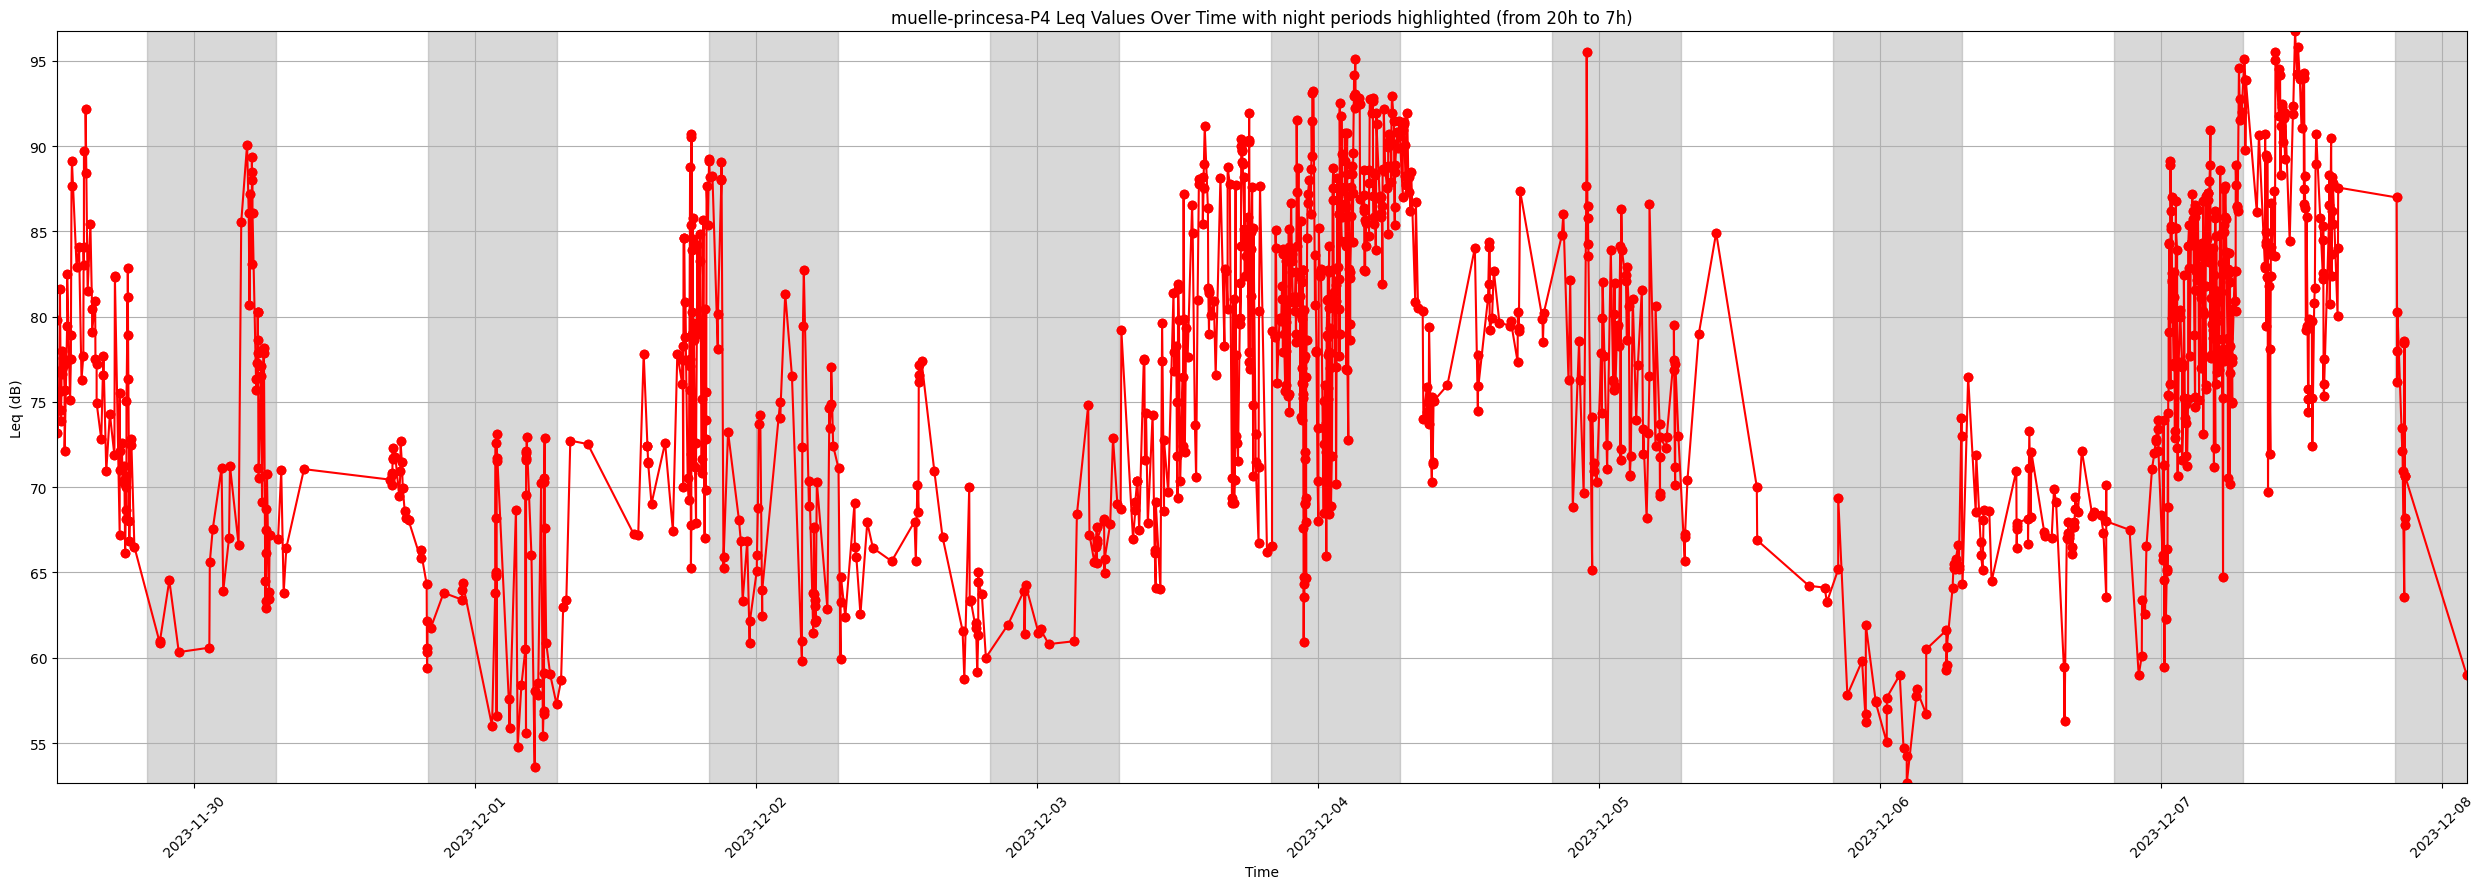

In [11]:
min_date = df_merged['start_time'].dt.date.min()
max_date = df_merged['start_time'].dt.date.max()

plt.figure(figsize=(25, 9))
plt.plot(df_merged['start_time'], df_merged['LAeq'], marker='o', linestyle='-', color='red')
# highlighting night periods
for single_date in pd.date_range(min_date, max_date):
    start_night = pd.Timestamp.combine(single_date, pd.Timestamp('20:00:00').time())
    end_night = pd.Timestamp.combine(single_date + pd.Timedelta(days=1), pd.Timestamp('07:00:00').time())
    plt.fill_betweenx(y=[df_merged['LAeq'].min(), df_merged['LAeq'].max()], 
                      x1=start_night, x2=end_night, color='grey', alpha=0.3)

plt.title(f'{title} Leq Values Over Time with night periods highlighted (from 20h to 7h)')
plt.xlabel('Time')
plt.ylabel('Leq (dB)')
plt.grid(True)
plt.xticks(rotation=45)
plt.xlim(df_merged['start_time'].iloc[0], df_merged['start_time'].iloc[-1])
plt.ylim(df_merged['LAeq'].min(), df_merged['LAeq'].max())
plt.tight_layout()
# plt.show()

#save the plot
plt.savefig(os.path.join(folder_output, f'{title}_peak_leq_night.png'))
df_merged.to_csv(os.path.join(folder_output, f'{title}_peak_leq_night.csv'))

## Ship activity

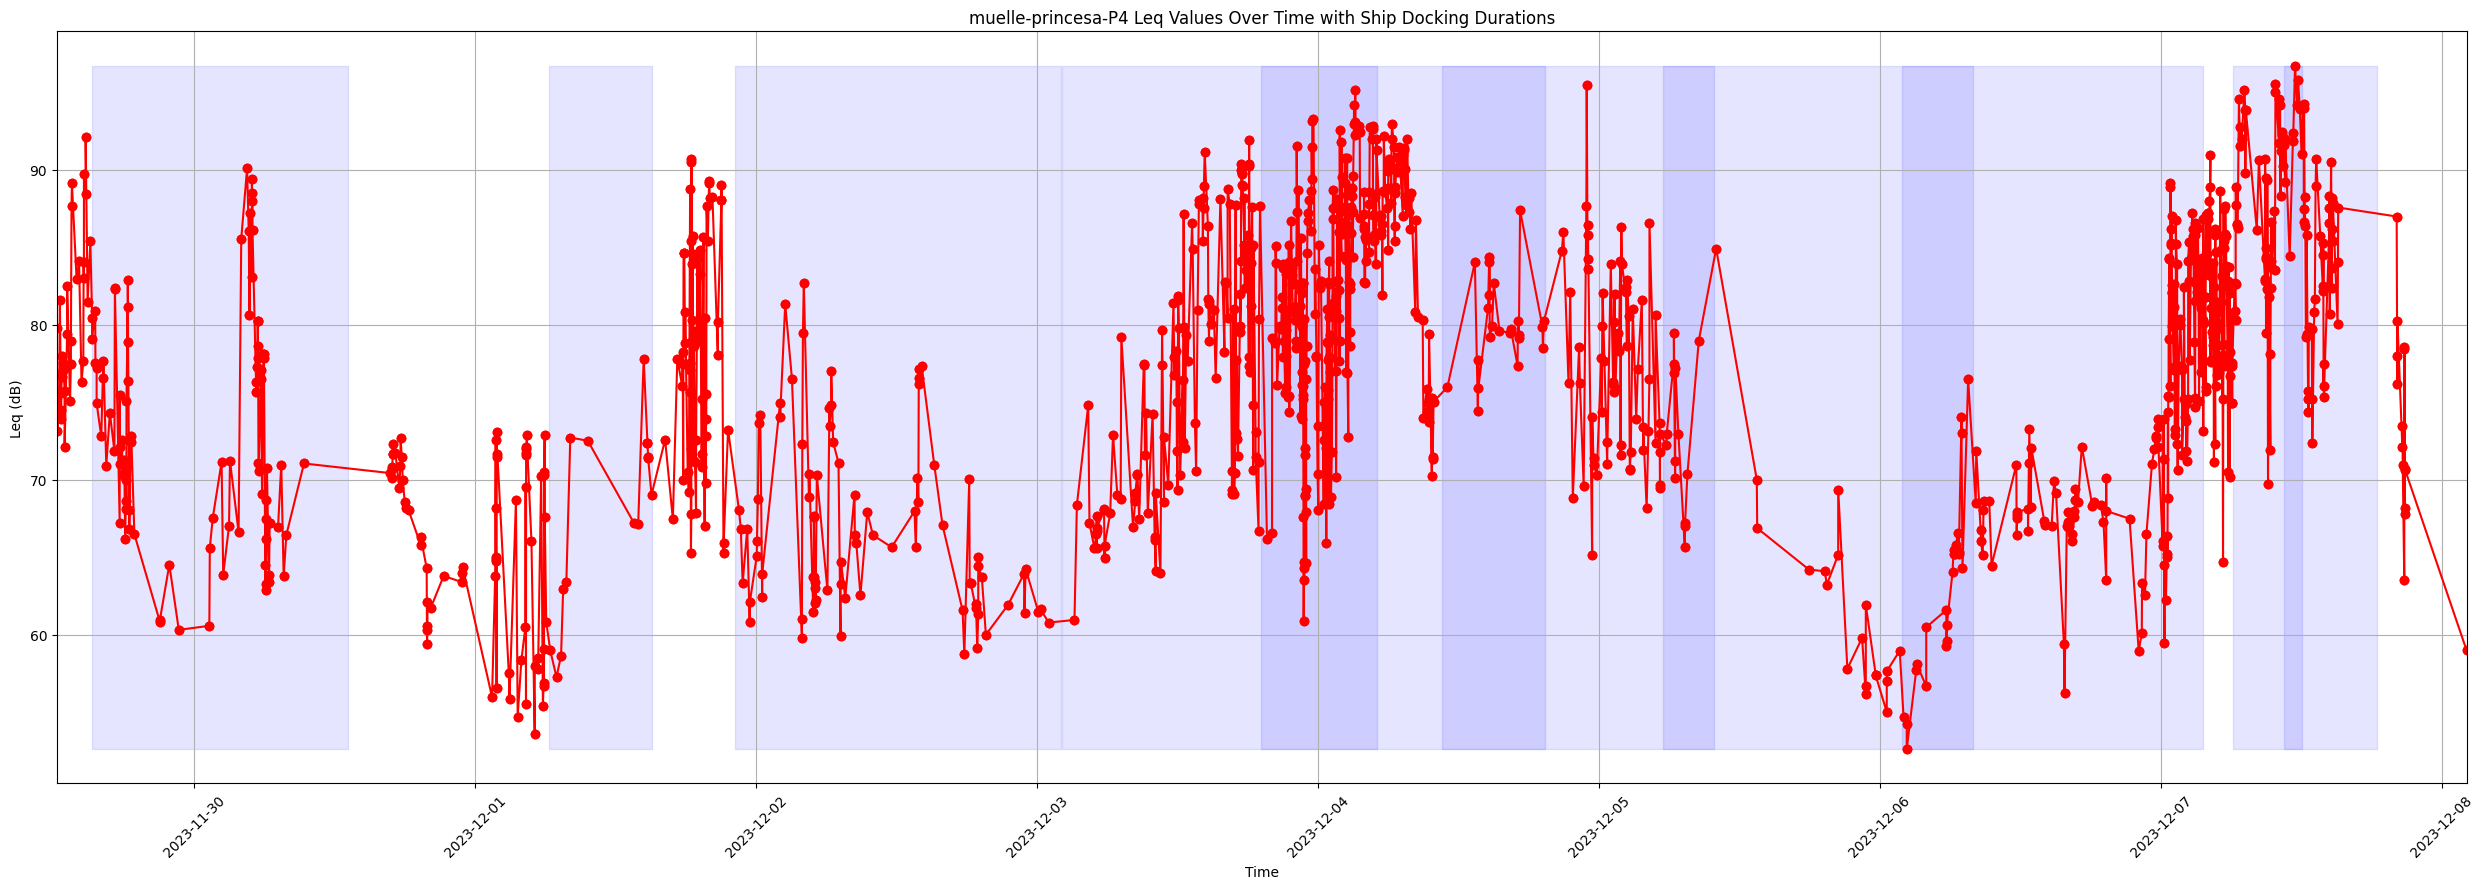

In [12]:
df_embarques['FECHA_HORA_ENTRADA_POR_PUNTAS'] = pd.to_datetime(
    df_embarques['FECHA_HORA_ENTRADA_POR_PUNTAS'], dayfirst=True, errors='coerce')

df_embarques['FECHA_HORA_SALIDA_POR_PUNTAS'] = pd.to_datetime(
    df_embarques['FECHA_HORA_SALIDA_POR_PUNTAS'], dayfirst=True, errors='coerce')

plt.figure(figsize=(25, 9))
plt.plot(df_merged['start_time'], df_merged['LAeq'], marker='o', linestyle='-', color='red')

for _, row in df_embarques.iterrows():
    plt.fill_betweenx(y=[df_merged['LAeq'].min(), df_merged['LAeq'].max()],
                      x1=row['FECHA_HORA_ENTRADA_POR_PUNTAS'], x2=row['FECHA_HORA_SALIDA_POR_PUNTAS'],
                      color='blue', alpha=0.1)

plt.title(f'{title} Leq Values Over Time with Ship Docking Durations')
plt.xlabel('Time')
plt.ylabel('Leq (dB)')
plt.grid(True)
plt.xticks(rotation=45)
plt.xlim(df_merged['start_time'].iloc[0], df_merged['start_time'].iloc[-1])
plt.tight_layout()
# plt.show()

#save the plot
plt.savefig(os.path.join(folder_output, f'{title}_peak_leq_ships.png'))
df_merged.to_csv(os.path.join(folder_output, f'{title}_peak_leq_ships.csv'))

In [13]:
df_merged.columns

Index(['filename', 'start_time', 'end_time', 'duration', 'class',
       'predictions', 'LAeq', 'LA_values', 'date', 'day', 'hour', 'weekday',
       'day_name', 'indicador_str', 'night_str', 'mid', 'display_name',
       'iso_taxonomy', 'Brown_Level_2', 'Brown_Level_3', 'NoisePort_Level_1',
       'NoisePort_Level_2'],
      dtype='object')

## Density distribution of peaks data

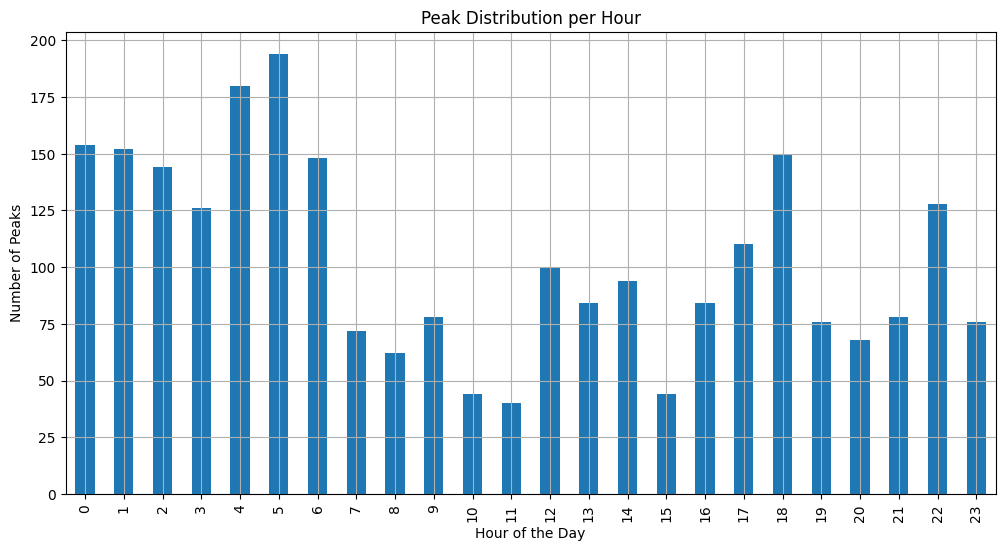

In [14]:
hourly_peaks = df_merged.groupby('hour').size()

plt.figure(figsize=(12, 6))

hourly_peaks.plot(kind='bar')
plt.title('Peak Distribution per Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Peaks')
plt.grid(True)
plt.show()

# kernel density estimation

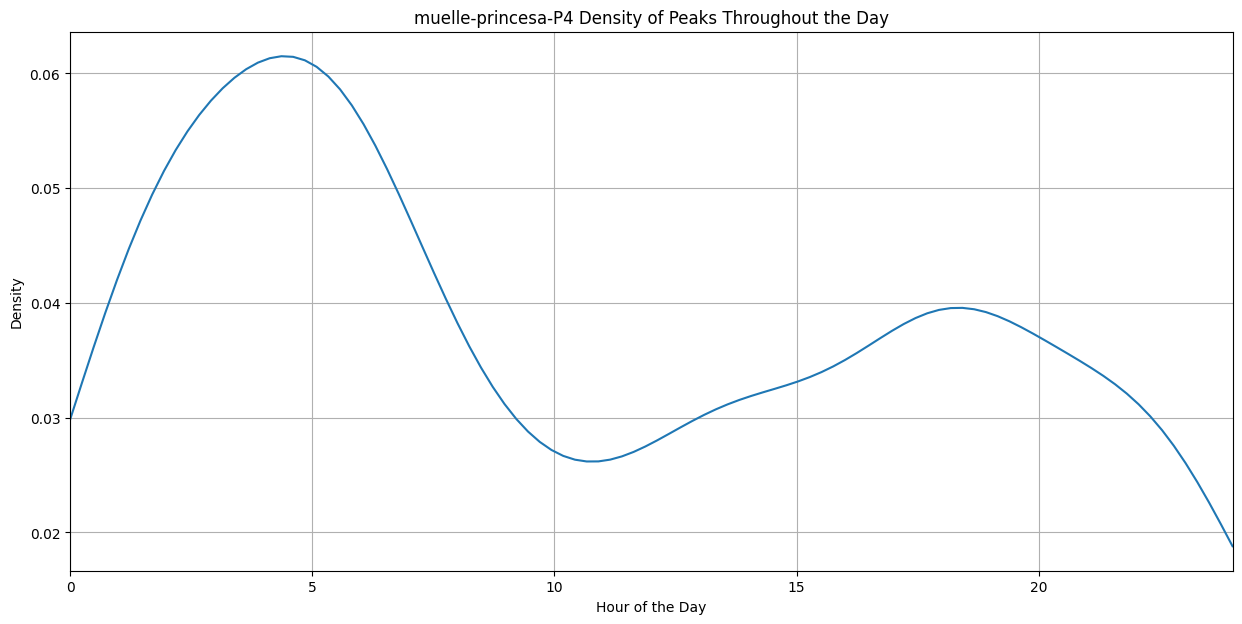

In [15]:
# data for KDE
time_of_day = df_merged['start_time'].dt.hour + df_merged['start_time'].dt.minute/60

# KDE plot
density = gaussian_kde(time_of_day)
xs = np.linspace(0,24,100)
density.covariance_factor = lambda : .25
density._compute_covariance()


plt.figure(figsize=(15, 7))

plt.plot(xs, density(xs))
plt.title(f'{title} Density of Peaks Throughout the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Density')
# adjust blank space in the beggining and end of the plot
plt.xlim(0, 24)
plt.grid(True)
# plt.show()

#save the plot
plt.savefig(os.path.join(folder_output, f'{title}_peak_density.png'))
df.to_csv(os.path.join(folder_output, f'{title}_peak_density.csv'))

# heat map 

In [16]:
df_merged.columns

Index(['filename', 'start_time', 'end_time', 'duration', 'class',
       'predictions', 'LAeq', 'LA_values', 'date', 'day', 'hour', 'weekday',
       'day_name', 'indicador_str', 'night_str', 'mid', 'display_name',
       'iso_taxonomy', 'Brown_Level_2', 'Brown_Level_3', 'NoisePort_Level_1',
       'NoisePort_Level_2'],
      dtype='object')

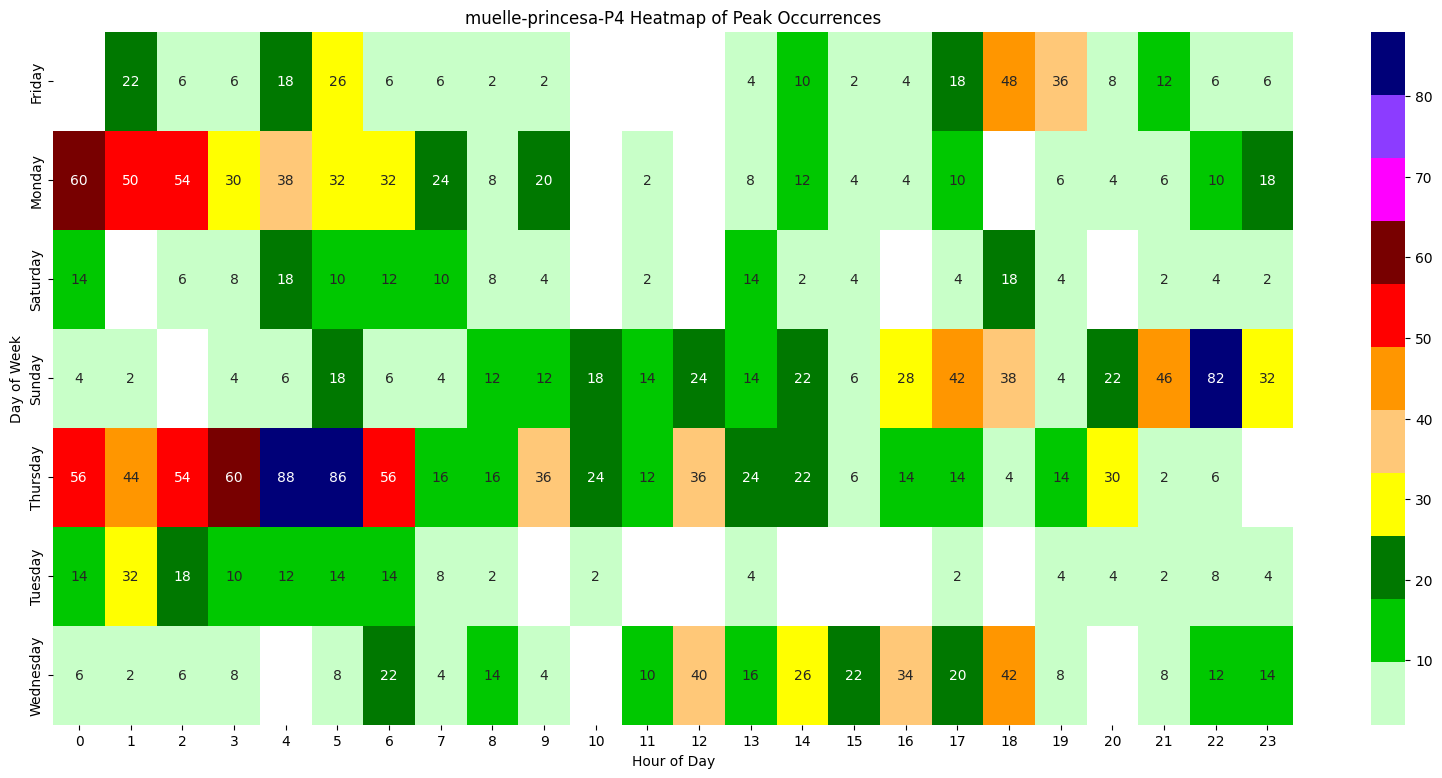

In [17]:
pivot_table = df_merged.pivot_table(
    index='day_name', 
    columns='hour', 
    aggfunc='size',
    )

pivot_table.replace(0, np.nan, inplace=True)

plt.figure(figsize=(20, 9))
sns.heatmap(pivot_table, annot=True, fmt=".0f", cmap=cmap_dict)
plt.title(f'{title} Heatmap of Peak Occurrences')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.yticks(np.arange(0.5, len(pivot_table.index), 1), pivot_table.index)  # set the yticks to be the day of the week
plt.xticks(np.arange(0.5, len(pivot_table.columns), 1), range(24))  
# plt.show()

#save the plot
plt.savefig(os.path.join(folder_output, f'{title}_peak_heatmap.png'))
df.to_csv(os.path.join(folder_output, f'{title}_peak_heatmap.csv'))

Start date: 2023-11-29 12:17:18
End date: 2023-12-08 02:06:41


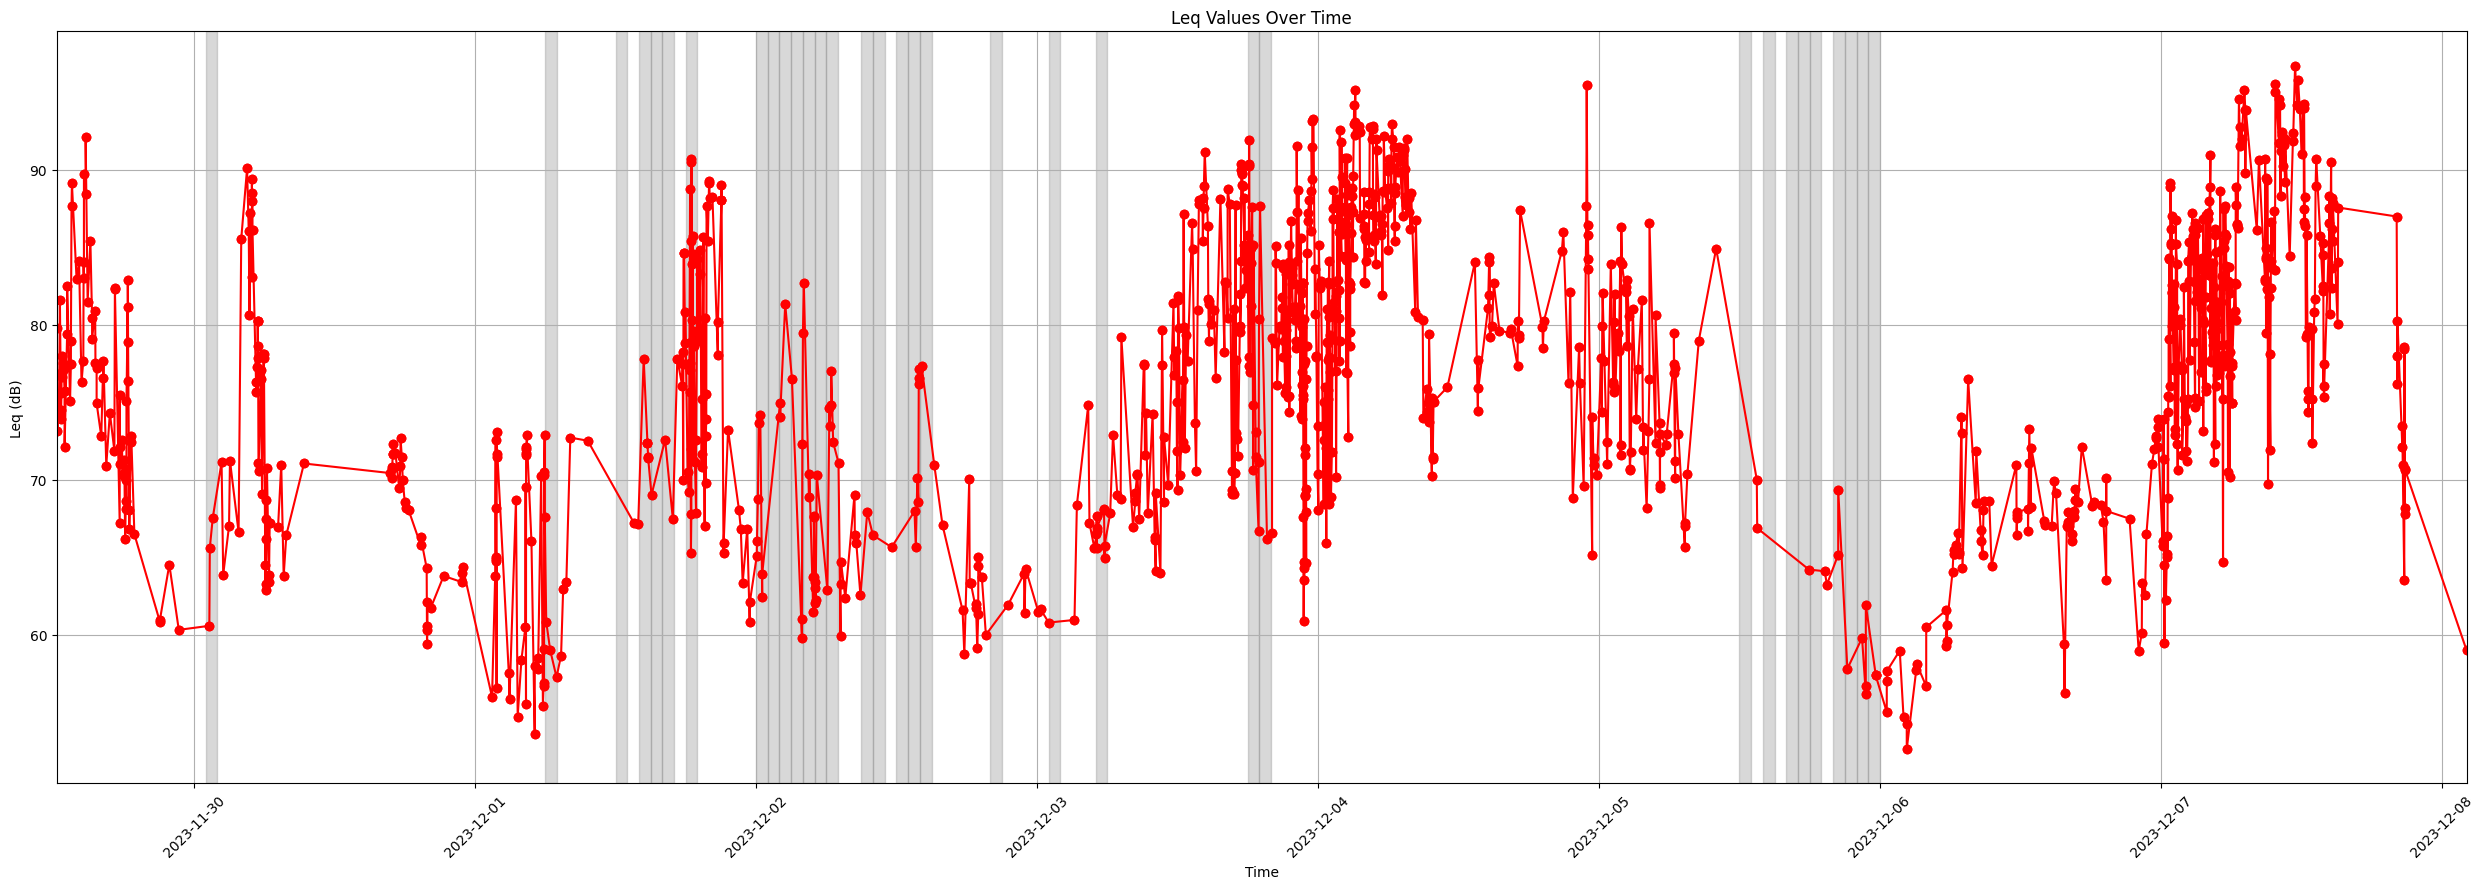

In [18]:
# print the end and start date
print(f"Start date: {start_date}")
print(f"End date: {end_date}")

df['Day'] = df['start_time'].dt.dayofweek
df['Hour'] = df['start_time'].dt.hour

pivot_table = df.pivot_table(
    index='Day', 
    columns='Hour', 
    aggfunc='size',
)

pivot_table.replace(0, np.nan, inplace=True)

# high density hours
threshold = 10 # threshold means the number of peaks in an hour to be considered as high density
high_density_hours = pivot_table.where(pivot_table > threshold).stack().index.tolist()

# laeq over time
plt.figure(figsize=(25, 9))
plt.plot(df_merged['start_time'], df_merged['LAeq'], marker='o', linestyle='-', color='red')
plt.title('Leq Values Over Time')
plt.xlabel('Time')
plt.ylabel('Leq (dB)')
plt.grid(True)
plt.xticks(rotation=45)

# high-density periods
base_date = df_merged['start_time'].dt.date.min()

# go through the high density hours and highlight them
for day, hour in high_density_hours:
    start_of_day = pd.Timestamp(str(base_date + pd.Timedelta(days=day)))
    start_time = start_of_day + pd.Timedelta(hours=hour)
    end_time = start_time + pd.Timedelta(hours=1)
    
    plt.axvspan(start_time, end_time, color='grey', alpha=0.3)

# blank space in the beginning and end of the plot
plt.xlim(df_merged['start_time'].iloc[0], df_merged['start_time'].iloc[-1])
plt.tight_layout()
plt.show()

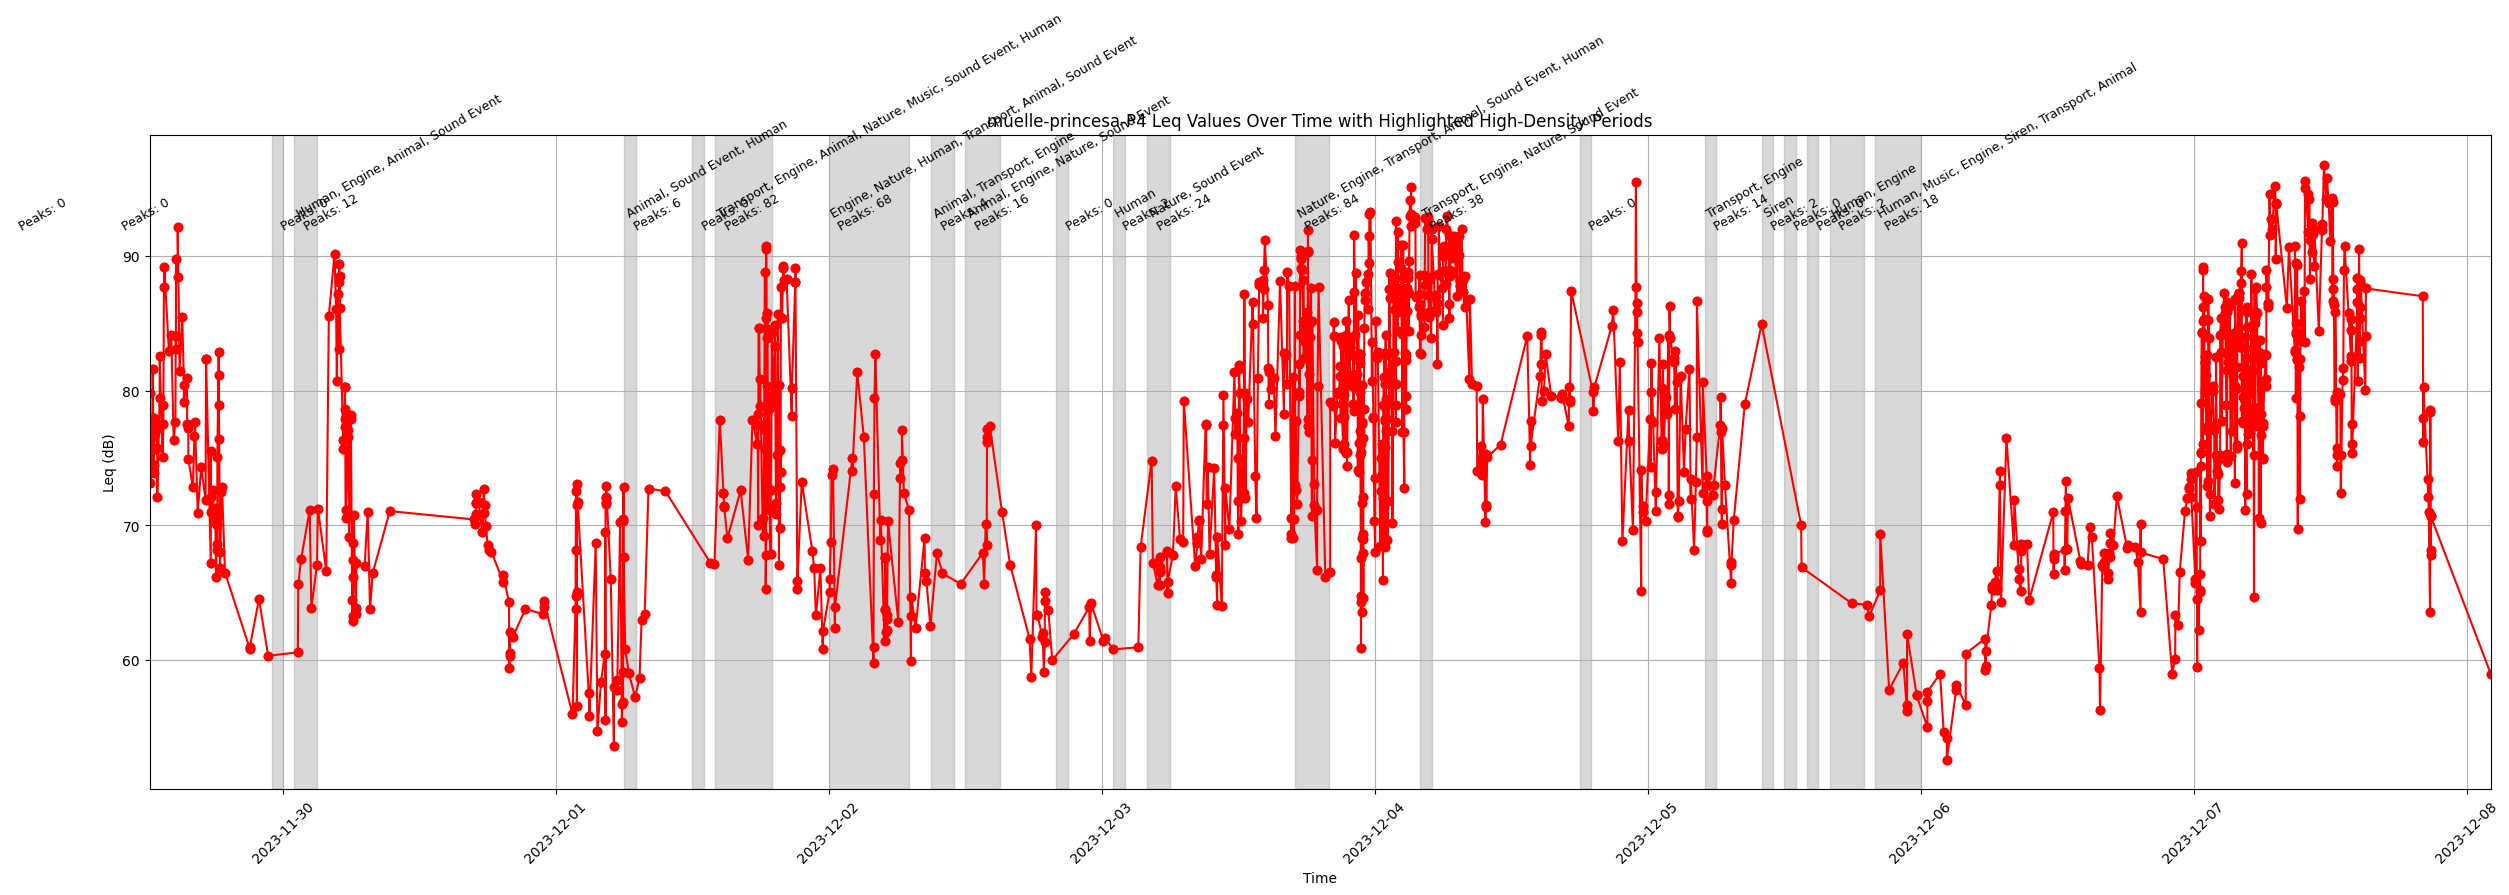

In [19]:
# high density hours
threshold = 8 # threshold means the number of peaks in an hour to be considered as high density
high_density_hours = pivot_table.where(pivot_table > threshold).stack().index.tolist()

plt.figure(figsize=(25, 9))

plt.plot(df_merged['start_time'], df_merged['LAeq'], marker='o', linestyle='-', color='red')
plt.title(f'{title} Leq Values Over Time with Highlighted High-Density Periods')
plt.xlabel('Time')
plt.ylabel('Leq (dB)')
plt.grid(True)
plt.xticks(rotation=45)

high_density_classes = {}
processed_hours = set()
high_density_hours_sorted = sorted(high_density_hours)
high_density_counts = {}

for i, (day, hour) in enumerate(high_density_hours_sorted):
    if (day, hour) in processed_hours:
        continue

    start_of_day = pd.Timestamp(str(base_date + pd.Timedelta(days=day)))
    start_time = start_of_day + pd.Timedelta(hours=hour)
    end_time = start_time + pd.Timedelta(hours=1)

    consecutive_non_density = 0
    j = i
    while j < len(high_density_hours_sorted) and consecutive_non_density < 2:
        next_day, next_hour = high_density_hours_sorted[j]
        next_start_of_day = pd.Timestamp(str(base_date + pd.Timedelta(days=next_day)))
        next_start_time = next_start_of_day + pd.Timedelta(hours=next_hour)
        if next_start_time == end_time:
            end_time += pd.Timedelta(hours=1)
            processed_hours.add((next_day, next_hour))
            consecutive_non_density = 0
        else:
            consecutive_non_density += 1
        j += 1

    plt.axvspan(start_time, end_time, color='grey', alpha=0.3)

    mask = (df_merged['start_time'] >= start_time) & (df_merged['start_time'] < end_time)
    unique_classes = df_merged.loc[mask, 'NoisePort_Level_1'].unique()
    high_density_classes[(start_time, end_time)] = unique_classes
    count_peaks = df_merged.loc[mask].shape[0]
    high_density_counts[(start_time, end_time)] = count_peaks

    # Annotation for the high-density period including class and number of peaks
    annotation_text = f"{', '.join(unique_classes)} \nPeaks: {count_peaks}"
    plt.text(start_time, df_merged['LAeq'].max() * 0.95, annotation_text, fontsize=9, rotation=30, ha='left')

plt.xlim(df_merged['start_time'].min(), df_merged['start_time'].max())
plt.tight_layout()

# Save the plot and data
plt.savefig(os.path.join(folder_output, f'{title}_peak_leq_high_density.png'))
df_merged.to_csv(os.path.join(folder_output, f'{title}_peak_leq_high_density.csv'))

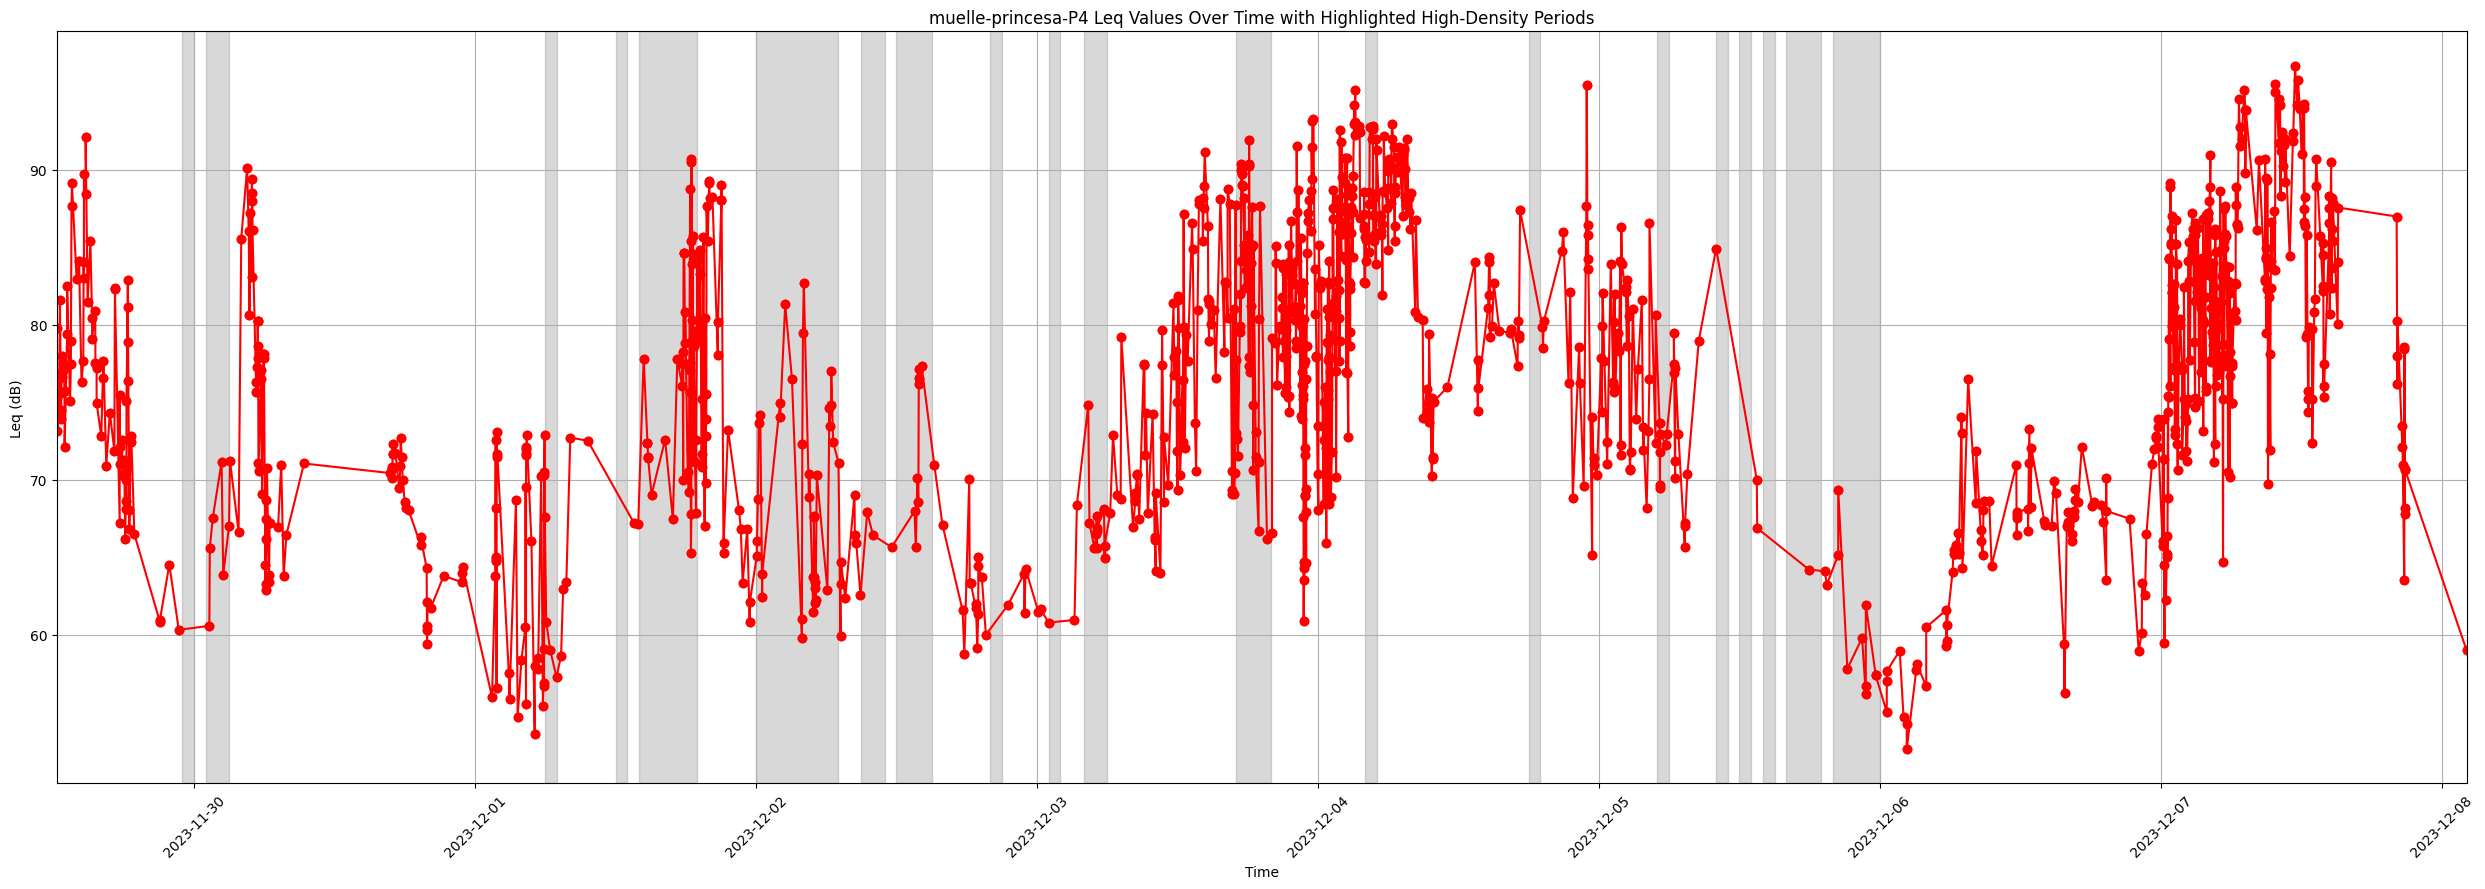

High-density period from 2023-11-29 00:00:00 to 2023-11-29 08:00:00 includes classes: 
High-density period from 2023-11-29 09:00:00 to 2023-11-29 10:00:00 includes classes: 
High-density period from 2023-11-29 23:00:00 to 2023-11-30 00:00:00 includes classes: 
High-density period from 2023-11-30 01:00:00 to 2023-11-30 03:00:00 includes classes: Human, Engine, Animal, Sound Event
High-density period from 2023-12-01 06:00:00 to 2023-12-01 07:00:00 includes classes: Animal, Sound Event, Human
High-density period from 2023-12-01 12:00:00 to 2023-12-01 13:00:00 includes classes: 
High-density period from 2023-12-01 14:00:00 to 2023-12-01 19:00:00 includes classes: Transport, Engine, Animal, Nature, Music, Sound Event, Human
High-density period from 2023-12-02 00:00:00 to 2023-12-02 07:00:00 includes classes: Engine, Nature, Human, Transport, Animal, Sound Event
High-density period from 2023-12-02 09:00:00 to 2023-12-02 11:00:00 includes classes: Animal, Transport, Engine
High-density period

In [20]:
plt.figure(figsize=(25, 9))

plt.plot(df_merged['start_time'], df_merged['LAeq'], marker='o', linestyle='-', color='red')
plt.title(f'{title} Leq Values Over Time with Highlighted High-Density Periods')
plt.xlabel('Time')
plt.ylabel('Leq (dB)')
plt.grid(True)
plt.xticks(rotation=45)

high_density_classes = {}
processed_hours = set()
high_density_hours_sorted = sorted(high_density_hours)

for i, (day, hour) in enumerate(high_density_hours_sorted):
    if (day, hour) in processed_hours:
        continue  # skiping this hour if it has already been processed

    start_of_day = pd.Timestamp(str(base_date + pd.Timedelta(days=day)))
    start_time = start_of_day + pd.Timedelta(hours=hour)
    end_time = start_time + pd.Timedelta(hours=1)

    # check for continuity in high-density periods
    consecutive_non_density = 0
    j = i
    while j < len(high_density_hours_sorted) and consecutive_non_density < 2:
        next_day, next_hour = high_density_hours_sorted[j]
        next_start_of_day = pd.Timestamp(str(base_date + pd.Timedelta(days=next_day)))
        next_start_time = next_start_of_day + pd.Timedelta(hours=next_hour)
        if next_start_time == end_time:
            end_time += pd.Timedelta(hours=1)
            processed_hours.add((next_day, next_hour))
            consecutive_non_density = 0  # reset consecutive non-density counter
        else:
            consecutive_non_density += 1  # increment if there is a gap
        j += 1

    plt.axvspan(start_time, end_time, color='grey', alpha=0.3)

    mask = (df_merged['start_time'] >= start_time) & (df_merged['start_time'] < end_time)
    unique_classes = df_merged.loc[mask, 'NoisePort_Level_1'].unique()

    high_density_classes[(start_time, end_time)] = unique_classes

plt.xlim(df_merged['start_time'].min(), df_merged['start_time'].max())
plt.tight_layout()
plt.show()


high_density_counts = {}
for period, classes in high_density_classes.items():
    print(f"High-density period from {period[0]} to {period[1]} includes classes: {', '.join(classes)}")
    start_time, end_time = period
    mask = (df_merged['start_time'] >= start_time) & (df_merged['start_time'] < end_time)
    high_density_counts[period] = df_merged.loc[mask].shape[0]

for period, count in high_density_counts.items():
    print(f"High-density period from {period[0]} to {period[1]} has {count} peaks")

# print how many high-density periods are there
print(f"Total number of high-density periods: {len(high_density_counts)}")



In [21]:
df

,filename,start_time,end_time,duration,classes,predictions,leq,LA_values,date,day,hour,weekday,day_name,indicador_str,night_str,Day,Hour
datatime,,,,,,,,,,,,,,,,,
2023-11-29 12:17:18,\\192.168.205.117\AAC_Server\PUERTOS\NOISEPORT...,2023-11-29 12:17:18,2023-11-29 12:17:25,7.5,"[Bicycle, Vehicle]","[0.3083945, 0.14657761]",79.81,"[75.8, 78.23, 80.78, 80.0, 81.88]",2023-11-29,29,12,2,Wednesday,Ld,,2,12
2023-11-29 12:19:49,\\192.168.205.117\AAC_Server\PUERTOS\NOISEPORT...,2023-11-29 12:19:49,2023-11-29 12:19:51,2.5,"[Wind, Wind noise (microphone)]","[0.2714036, 0.26486522]",73.15,"[71.09, 74.59, 73.07]",2023-11-29,29,12,2,Wednesday,Ld,,2,12
2023-11-29 12:28:56,\\192.168.205.117\AAC_Server\PUERTOS\NOISEPORT...,2023-11-29 12:28:56,2023-11-29 12:28:57,1.5,"[Vehicle, Wind noise (microphone)]","[0.1883349, 0.14215572]",74.54,"[72.94, 75.71]",2023-11-29,29,12,2,Wednesday,Ld,,2,12
2023-11-29 12:32:38,\\192.168.205.117\AAC_Server\PUERTOS\NOISEPORT...,2023-11-29 12:32:38,2023-11-29 12:32:40,2.5,"[Wind, Wind noise (microphone)]","[0.43858886, 0.42742014]",81.63,"[78.23, 81.94, 83.31]",2023-11-29,29,12,2,Wednesday,Ld,,2,12
2023-11-29 12:38:40,\\192.168.205.117\AAC_Server\PUERTOS\NOISEPORT...,2023-11-29 12:38:40,2023-11-29 12:38:41,1.5,"[Vehicle, Wind noise (microphone)]","[0.32059318, 0.17773132]",73.90,"[69.99, 75.92]",2023-11-29,29,12,2,Wednesday,Ld,,2,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-07 20:49:05,\\192.168.205.117\AAC_Server\PUERTOS\NOISEPORT...,2023-12-07 20:49:05,2023-12-07 20:49:06,1.5,"[Wind, Wind noise (microphone)]","[0.47863004, 0.44554484]",67.80,"[67.16, 68.35]",2023-12-07,7,20,3,Thursday,Le,,3,20
2023-12-07 20:49:09,\\192.168.205.117\AAC_Server\PUERTOS\NOISEPORT...,2023-12-07 20:49:09,2023-12-07 20:49:10,1.5,"[Vehicle, Aircraft]","[0.18894108, 0.123285554]",68.21,"[66.74, 69.3]",2023-12-07,7,20,3,Thursday,Le,,3,20
2023-12-07 20:49:13,\\192.168.205.117\AAC_Server\PUERTOS\NOISEPORT...,2023-12-07 20:49:13,2023-12-07 20:49:14,1.5,"[Wind, Wind noise (microphone)]","[0.5022389, 0.48235774]",70.66,"[67.96, 72.31]",2023-12-07,7,20,3,Thursday,Le,,3,20


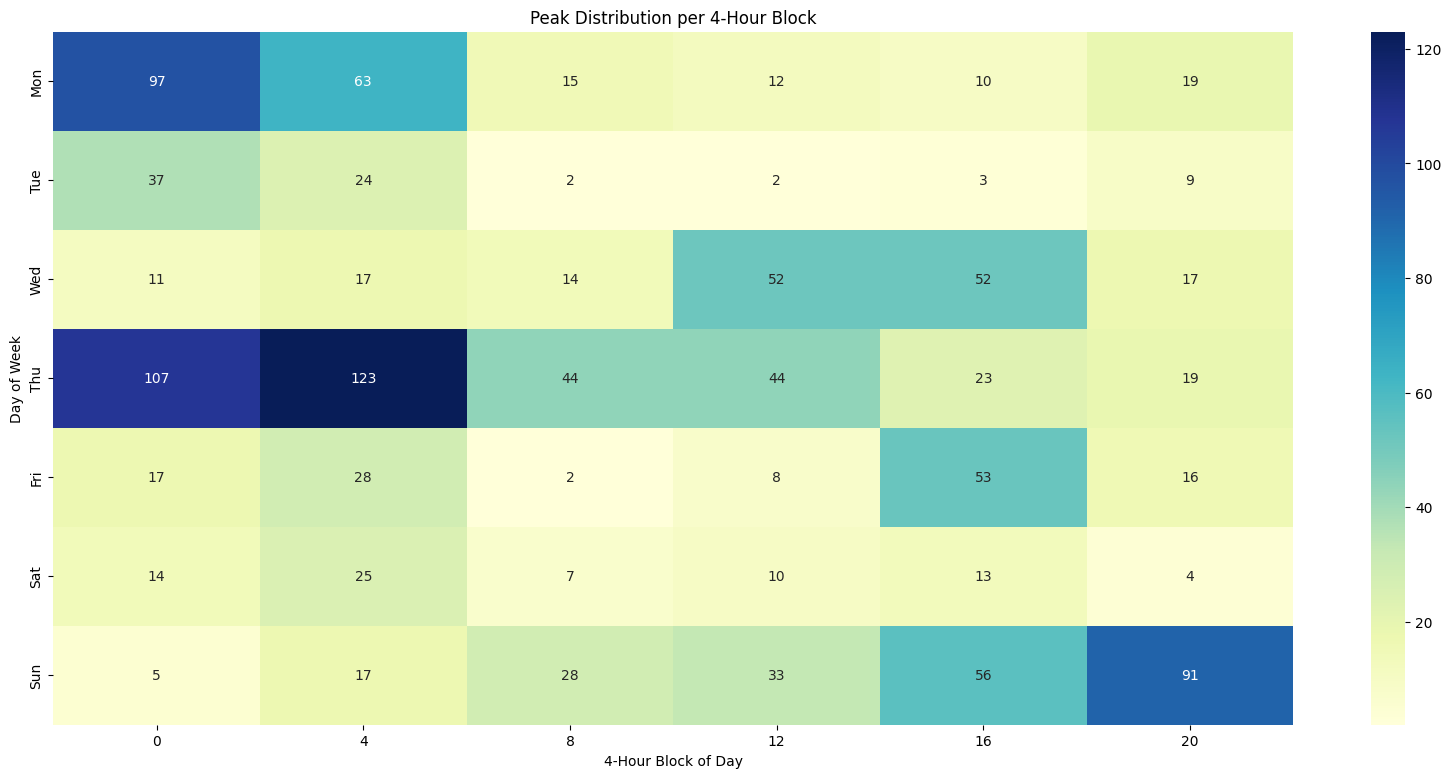

In [22]:
# 4h hourly blocks
df['4HourBlock'] = (df['start_time'].dt.hour // 4) * 4

pivot_table_4h = df.pivot_table(
    index='Day', 
    columns='4HourBlock', 
    aggfunc='size', 
    fill_value=0
)

plt.figure(figsize=(20, 9))
sns.heatmap(pivot_table_4h, annot=True, fmt="d", cmap="YlGnBu")
plt.title('Peak Distribution per 4-Hour Block')
plt.xlabel('4-Hour Block of Day')
plt.ylabel('Day of Week')
plt.yticks(np.arange(0.5, len(pivot_table_4h.index), 1), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

### Testing diferents plots

# box plot

Plot saved in \\192.168.205.123\aac_server\PUERTOS\NOISEPORT\20231129_SANTUR\5-Resultados\muelle-princesa-P4\SPL\Peaks\Graphic_analysis\muelle-princesa-P4_box_plot.png


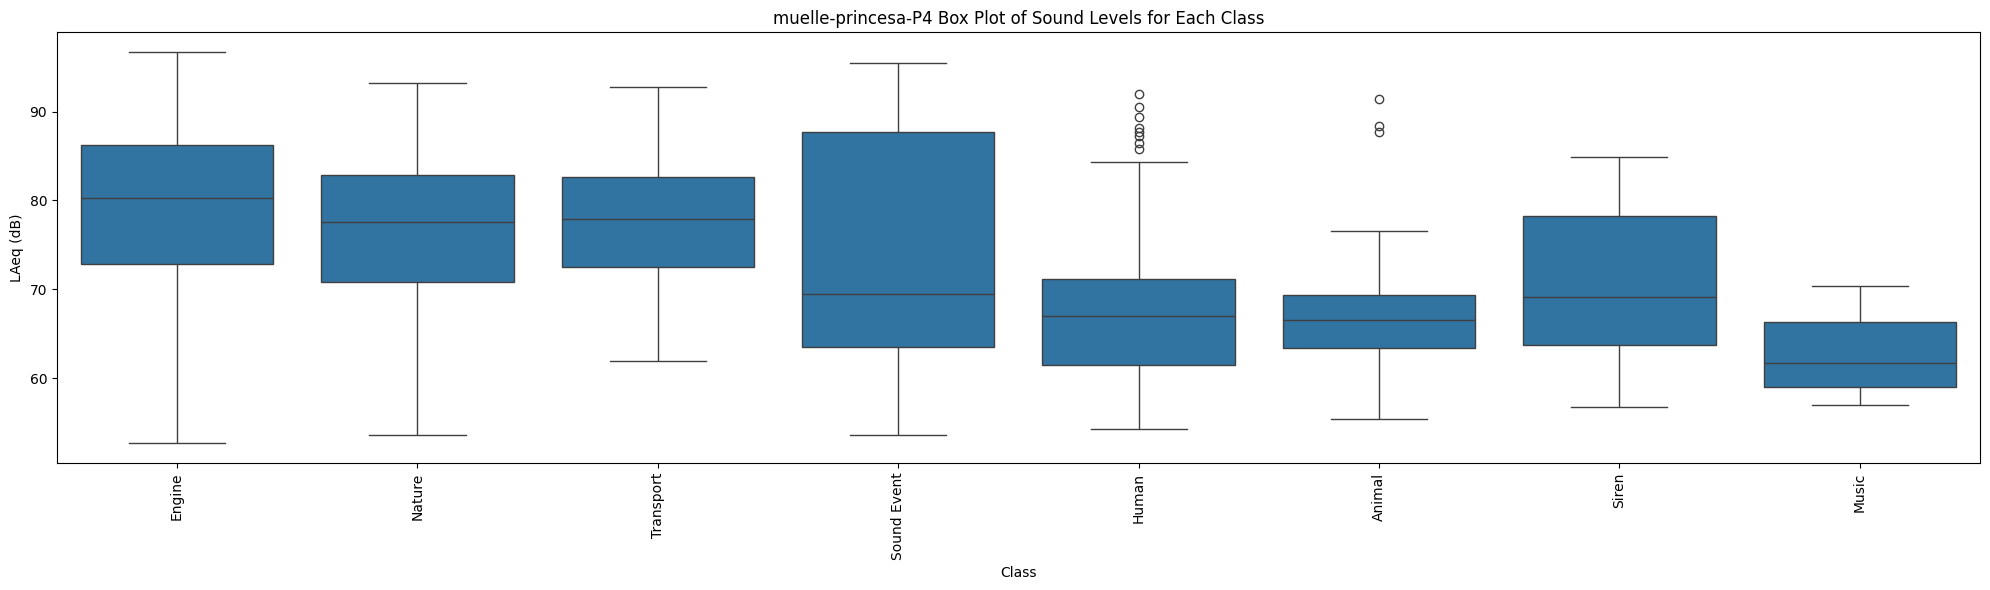

In [23]:
plt.figure(figsize=(20, 6))

sns.boxplot(data=df_merged, x='NoisePort_Level_1', y='LAeq')
plt.xticks(rotation=90)

plt.title(f'{title} Box Plot of Sound Levels for Each Class')
plt.xlabel('Class')
plt.ylabel('LAeq (dB)')
plt.tight_layout()
# plt.show()

# save the plot
plt.savefig(os.path.join(folder_output, f'{title}_box_plot.png'))
print(f"Plot saved in {os.path.join(folder_output, f'{title}_box_plot.png')}")

# bar plot

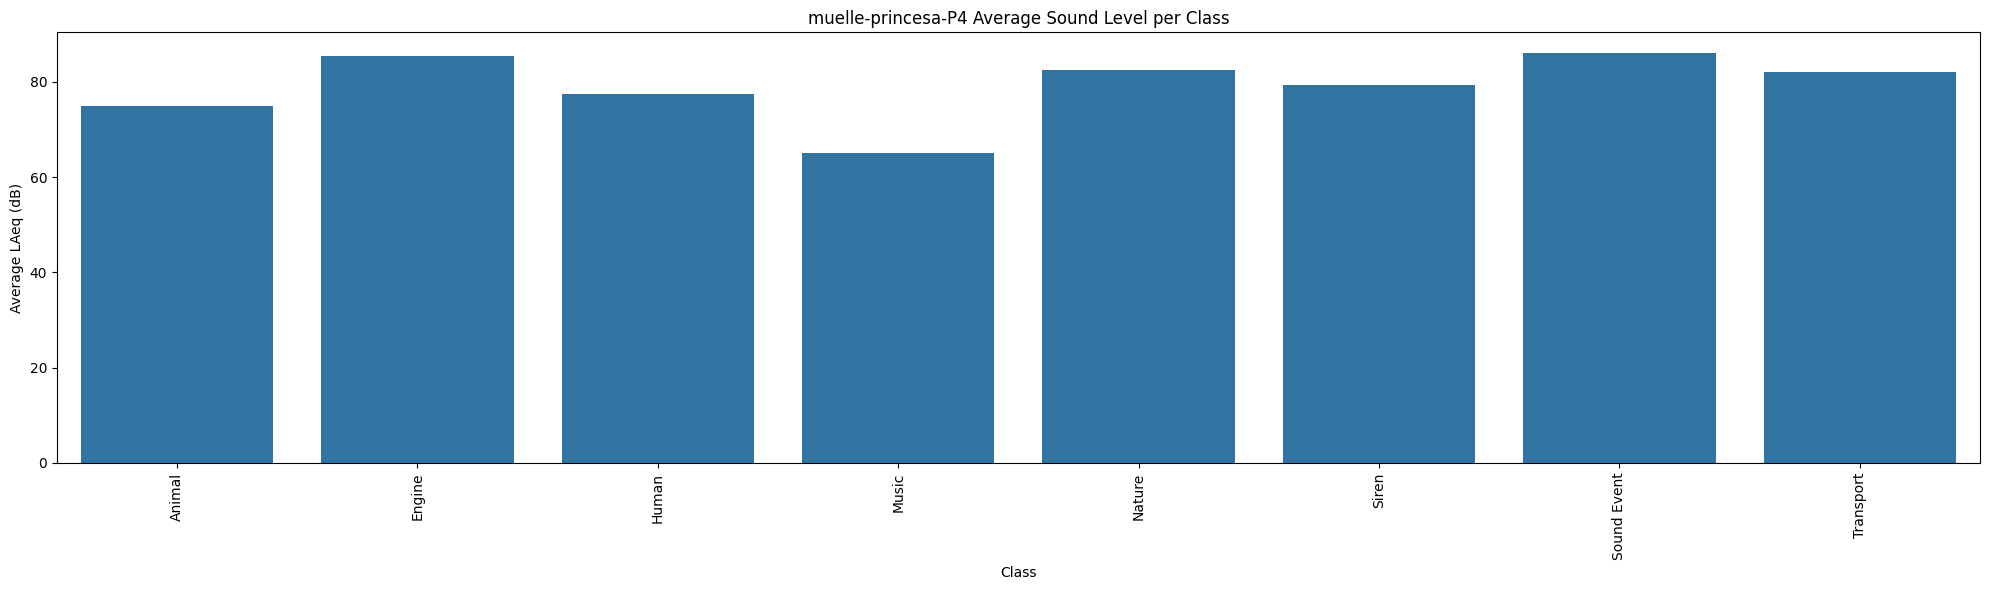

In [24]:
mean_levels = df_merged.groupby('NoisePort_Level_1')['LAeq'].apply(leq).reset_index()

plt.figure(figsize=(20, 6))

sns.barplot(data=mean_levels, x='NoisePort_Level_1', y='LAeq')
plt.xticks(rotation=90)

plt.title(f'{title} Average Sound Level per Class')
plt.xlabel('Class')
plt.ylabel('Average LAeq (dB)')
plt.tight_layout()
# plt.show()

# save the plot
plt.savefig(os.path.join(folder_output, f'{title}_average_sound_level.png'))
#save the csv file
mean_levels.to_csv(os.path.join(folder_output, f'{title}_average_sound_level.csv'))

# Heatmap

C:\Users\scjaa\AppData\Local\Temp\ipykernel_12536\2203239936.py:5: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior



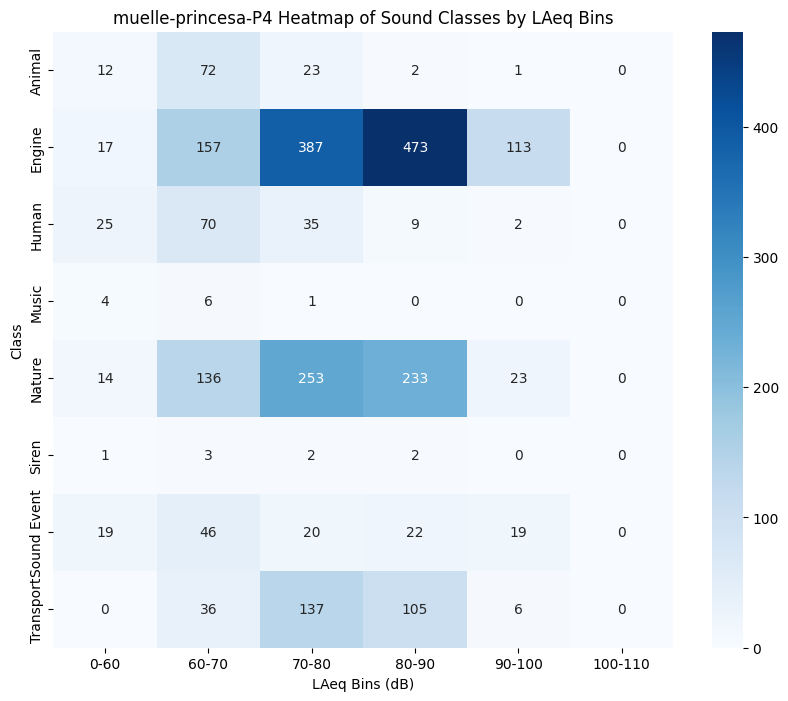

In [25]:
bins = [0, 60, 70, 80, 90, 100, 110]
labels = ['0-60', '60-70', '70-80', '80-90', '90-100', '100-110']
df_merged['LAeq_bins'] = pd.cut(df_merged['LAeq'], bins=bins, labels=labels, include_lowest=True)

heatmap_data = df_merged.pivot_table(index='NoisePort_Level_1', columns='LAeq_bins', values='LAeq', aggfunc='count').fillna(0)
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap='Blues')
plt.title(f'{title} Heatmap of Sound Classes by LAeq Bins')
plt.xlabel('LAeq Bins (dB)')
plt.ylabel('Class')
# plt.show()

#sa plot
plt.savefig(os.path.join(folder_output, f'{title}_heatmap_sound_classes.png'))
#save the csv file
heatmap_data.to_csv(os.path.join(folder_output, f'{title}_heatmap_sound_classes.csv'))

In [32]:
df_merged

,filename,start_time,end_time,duration,class,predictions,LAeq,LA_values,date,day,...,indicador_str,night_str,mid,display_name,iso_taxonomy,Brown_Level_2,Brown_Level_3,NoisePort_Level_1,NoisePort_Level_2,LAeq_bins
0,\\192.168.205.117\AAC_Server\PUERTOS\NOISEPORT...,2023-11-29 12:17:18,2023-11-29 12:17:25,7.5,Bicycle,"[0.3083945, 0.14657761]",79.81,"[75.8, 78.23, 80.78, 80.0, 81.88]",2023-11-29,29,...,Ld,,/m/0199g,Bicycle,non motorized,Human movement,non motorized,Engine,Vehicle,70-80
1,\\192.168.205.117\AAC_Server\PUERTOS\NOISEPORT...,2023-11-29 12:17:18,2023-11-29 12:17:25,7.5,Vehicle,"[0.3083945, 0.14657761]",79.81,"[75.8, 78.23, 80.78, 80.0, 81.88]",2023-11-29,29,...,Ld,,/m/07yv9,Vehicle,Roadway traffic,Motorised transport,roadway traffic,Engine,Vehicle,70-80
2,\\192.168.205.117\AAC_Server\PUERTOS\NOISEPORT...,2023-11-29 12:19:49,2023-11-29 12:19:51,2.5,Wind,"[0.2714036, 0.26486522]",73.15,"[71.09, 74.59, 73.07]",2023-11-29,29,...,Ld,,/m/03m9d0z,Wind,Wind,Geonature,wind,Nature,Wind,70-80
3,\\192.168.205.117\AAC_Server\PUERTOS\NOISEPORT...,2023-11-29 12:19:49,2023-11-29 12:19:51,2.5,Wind noise (microphone),"[0.2714036, 0.26486522]",73.15,"[71.09, 74.59, 73.07]",2023-11-29,29,...,Ld,,/t/dd00092,Wind noise (microphone),Wind,Geonature,wind,Nature,Wind,70-80
4,\\192.168.205.117\AAC_Server\PUERTOS\NOISEPORT...,2023-11-29 12:28:56,2023-11-29 12:28:57,1.5,Vehicle,"[0.1883349, 0.14215572]",74.54,"[72.94, 75.71]",2023-11-29,29,...,Ld,,/m/07yv9,Vehicle,Roadway traffic,Motorised transport,roadway traffic,Engine,Vehicle,70-80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2481,\\192.168.205.117\AAC_Server\PUERTOS\NOISEPORT...,2023-12-07 20:49:13,2023-12-07 20:49:14,1.5,Wind noise (microphone),"[0.5022389, 0.48235774]",70.66,"[67.96, 72.31]",2023-12-07,7,...,Le,,/t/dd00092,Wind noise (microphone),Wind,Geonature,wind,Nature,Wind,70-80
2482,\\192.168.205.117\AAC_Server\PUERTOS\NOISEPORT...,2023-12-07 20:50:28,2023-12-07 20:50:31,3.5,Speech,"[0.19509986, 0.19083287]",70.68,"[66.87, 70.87, 72.55]",2023-12-07,7,...,Le,,/m/09x0r,Speech,Voice,Voice,speech,Human,Voice,70-80
2483,\\192.168.205.117\AAC_Server\PUERTOS\NOISEPORT...,2023-12-07 20:50:28,2023-12-07 20:50:31,3.5,Vehicle,"[0.19509986, 0.19083287]",70.68,"[66.87, 70.87, 72.55]",2023-12-07,7,...,Le,,/m/07yv9,Vehicle,Roadway traffic,Motorised transport,roadway traffic,Engine,Vehicle,70-80
2484,\\192.168.205.117\AAC_Server\PUERTOS\NOISEPORT...,2023-12-08 02:06:41,2023-12-08 02:06:44,3.5,Animal,"[0.11167023, 0.06489019]",59.00,"[58.22, 58.69, 59.92]",2023-12-08,8,...,Ln,Jueves-Viernes,/m/0jbk,Animal,Nature,Animal,Animal,Animal,Animal,0-60


In [31]:
print(df_merged.columns)

Index(['filename', 'start_time', 'end_time', 'duration', 'class',
       'predictions', 'LAeq', 'LA_values', 'date', 'day', 'hour', 'weekday',
       'day_name', 'indicador_str', 'night_str', 'mid', 'display_name',
       'iso_taxonomy', 'Brown_Level_2', 'Brown_Level_3', 'NoisePort_Level_1',
       'NoisePort_Level_2', 'LAeq_bins'],
      dtype='object')


In [ ]:
df_test_heatmap = df_merged

C:\Users\scjaa\AppData\Local\Temp\ipykernel_12536\3824032280.py:1: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior



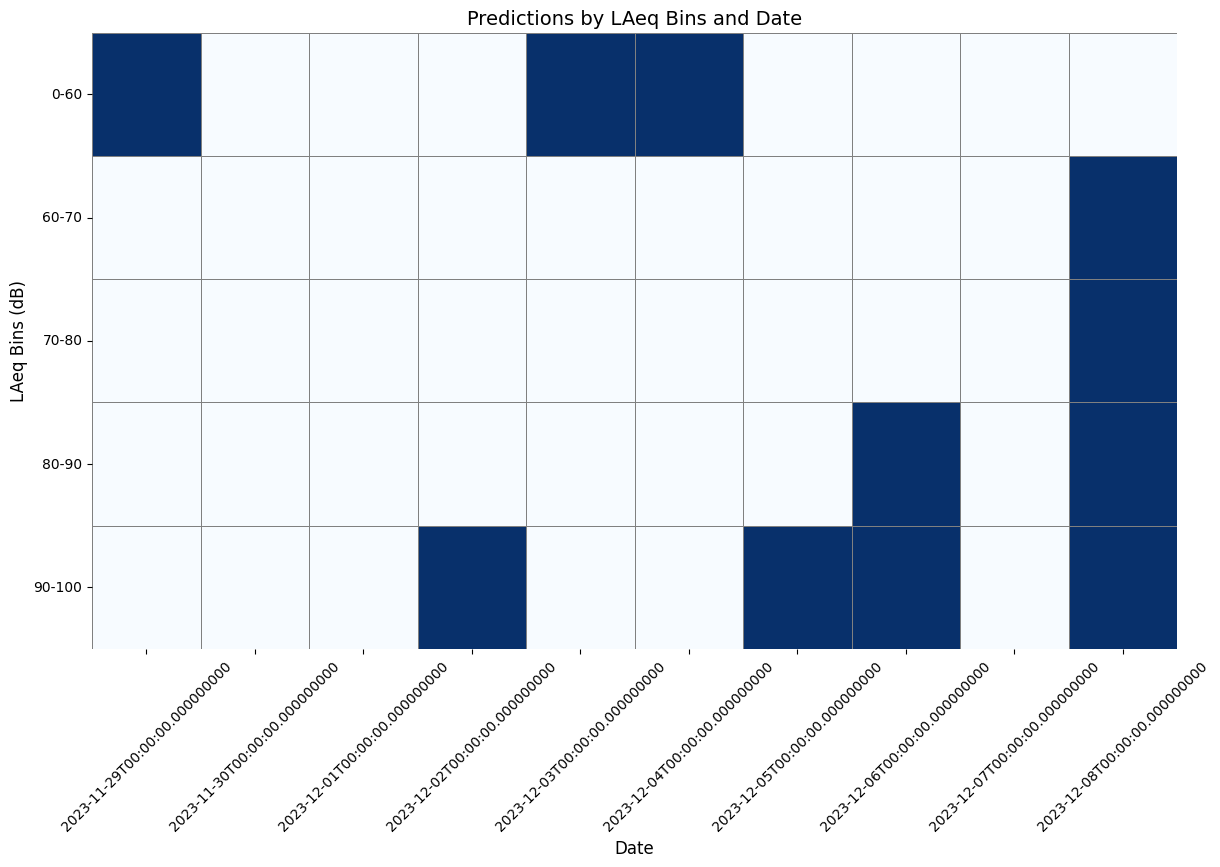

In [36]:
heatmap_data = df_merged.pivot_table(
    index='LAeq_bins', columns='date', values='class', aggfunc=lambda x: ', '.join(x)
)

# Plot heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(
    heatmap_data.isnull() * 1,  # Use a binary mask for the heatmap structure
    cmap='Blues', cbar=False, linewidths=0.5, linecolor='gray'
)

# Add labels and title
plt.title('Predictions by LAeq Bins and Date', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('LAeq Bins (dB)', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Save and show the plot
plt.savefig(os.path.join(folder_output, f'{title}_heatmap_predictions_by_bins.png'))
plt.show()


# Bubble Chart

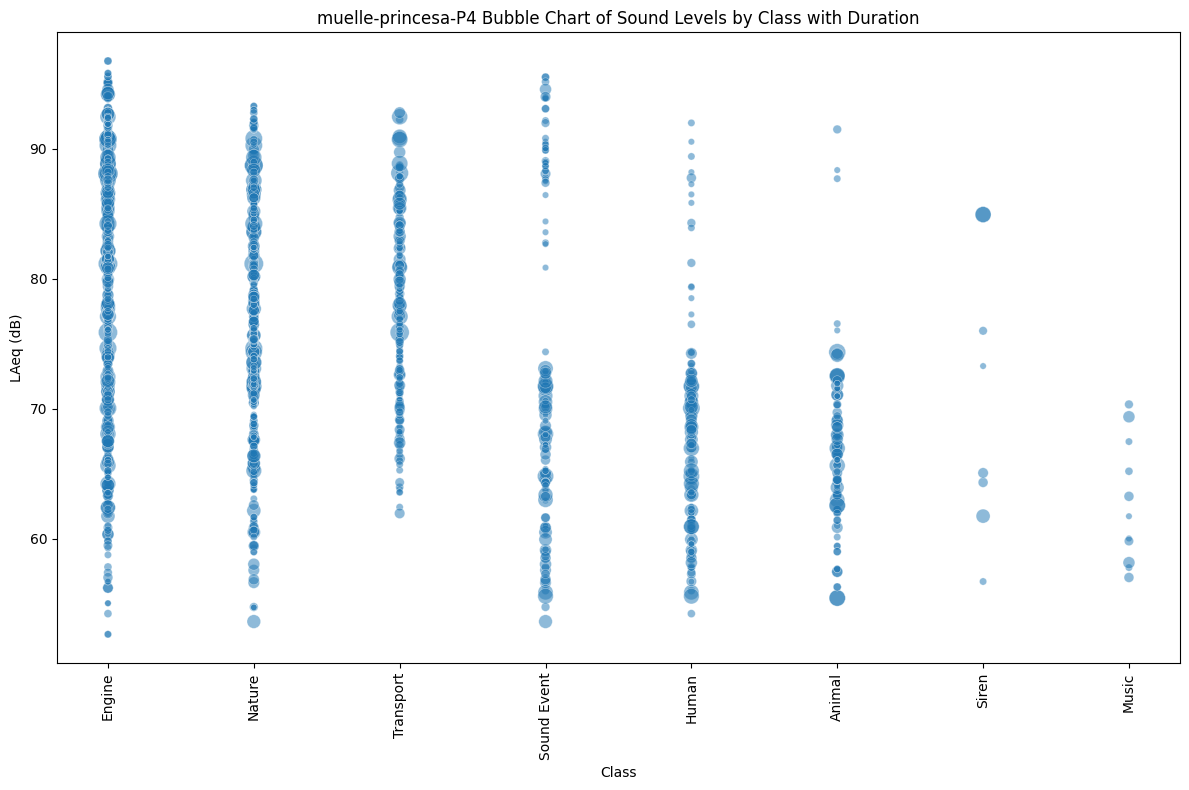

In [28]:
plt.figure(figsize=(12, 8))

sns.scatterplot(data=df_merged, x='NoisePort_Level_1', y='LAeq', size='duration', sizes=(20, 200), alpha=0.5, legend=None)
plt.xticks(rotation=90)

plt.title(f'{title} Bubble Chart of Sound Levels by Class with Duration')
plt.xlabel('Class')
plt.ylabel('LAeq (dB)')
plt.tight_layout()
# plt.show()

# save the plot
plt.savefig(os.path.join(folder_output, f'{title}_bubble_chart.png'))
#save the csv file
df_merged.to_csv(os.path.join(folder_output, f'{title}_bubble_chart.csv'))